# Advanced Blood Cell Image Dataset Generation

This notebook demonstrates a comprehensive workflow for generating a diverse blood cell detection dataset combining grid-based composites and segmented cells for YOLOv11 model training.

## Overview

The dataset creation process combines two powerful techniques:
1. **Grid-Based Composites**: Creating 1×1, 2×2, 3×3, and 4×4 composite images from original cell images
2. **Segmented Cell Placement**: Strategically placing cell segments on various backgrounds

## Cell Classes

The dataset includes 9 blood cell types:
- Basophil
- Eosinophil  
- Erythroblast
- Immunoglobin
- Lymphocyte
- Monocyte
- Neutrophil
- Platelet
- Lymphoblast

## Dataset Structure

The pipeline creates a comprehensive dataset with:
- Train (80%), Validation (15%), and Test (5%) splits
- 8,000 grid-based training images
- 8,000 segment-based training images
- Total combined dataset: 16,000 images with corresponding labels

## Implementation

This notebook implements the full workflow including:
- Data splitting with consistent train/val/test distribution
- Grid composite generation with proper label transformation
- Segment placement on backgrounds with collision detection
- Label generation in YOLO format
- Final dataset organization and YAML configuration

In [ ]:
import os
import glob
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [ ]:
# Define base paths
BASE_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments"
DATA_DIR = os.path.join(BASE_DIR, "data")
BG_DIR = os.path.join(BASE_DIR, "background_images")
OUTPUT_DIR = os.path.join(BASE_DIR, "combined_dataset")

# Define class names
CLASS_NAMES = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin',
              'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Dataset split parameters
TRAIN_RATIO = 0.8
VAL_RATIO = 0.15
TEST_RATIO = 0.05

# Target generation counts
GRID_IMAGES_PER_SPLIT = {'train': 6400, 'val': 1600}  # 8000 total grid images
SEGMENT_IMAGES_PER_SPLIT = {'train': 6400, 'val': 1600}  # 8000 total segment images

In [ ]:
# Create necessary directories
def create_directories():
    """Create all necessary directories for the combined dataset"""
    dirs = [
        # Main output directories
        OUTPUT_DIR,
        
        # Grid dataset directories
        os.path.join(OUTPUT_DIR, "grid_dataset"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "train", "images"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "train", "labels"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "val", "images"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "val", "labels"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "test", "images"),
        os.path.join(OUTPUT_DIR, "grid_dataset", "test", "labels"),
        
        # Segments dataset directories
        os.path.join(OUTPUT_DIR, "segments_dataset"),
        os.path.join(OUTPUT_DIR, "segments_dataset", "train", "images"),
        os.path.join(OUTPUT_DIR, "segments_dataset", "train", "labels"),
        os.path.join(OUTPUT_DIR, "segments_dataset", "val", "images"),
        os.path.join(OUTPUT_DIR, "segments_dataset", "val", "labels"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "test", "segments"),
        
        
        # Combined dataset directories
        os.path.join(OUTPUT_DIR, "combined_dataset"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "train", "images"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "train", "labels"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "val", "images"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "val", "labels"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "test", "images"),
        os.path.join(OUTPUT_DIR, "combined_dataset", "test", "labels"),
    ]
    
    for directory in dirs:
        os.makedirs(directory, exist_ok=True)
    
    print("Created all necessary directories")

def split_source_data():
    """
    Split the source data into train, val, and test sets.
    This ensures the same split is used for both grid and segment generation.
    Returns a dictionary with all source data split information.
    """
    print("Splitting source data into train, val, and test sets...")
    split_data = {
        'train': {'images': {}, 'labels': {}, 'segments': {}},
        'val': {'images': {}, 'labels': {}, 'segments': {}},
        'test': {'images': {}, 'labels': {}, 'segments': {}}
    }
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(DATA_DIR, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}")
            continue
            
        # Get all images for this class
        img_dir = os.path.join(class_dir, "images")
        lbl_dir = os.path.join(class_dir, "labels")
        seg_dir = os.path.join(class_dir, "segmented_cells")
        
        # Collect all image paths
        image_paths = list(glob.glob(os.path.join(img_dir, "*.jpg"))) + list(glob.glob(os.path.join(img_dir, "*.png")))
        
        if not image_paths:
            print(f"Warning: No images found for class {class_name}")
            continue
            
        # Shuffle and split
        random.shuffle(image_paths)
        total_images = len(image_paths)
        
        train_size = int(total_images * TRAIN_RATIO)
        val_size = int(total_images * VAL_RATIO)
        test_size = total_images - train_size - val_size
        
        # Assign to splits
        train_images = image_paths[:train_size]
        val_images = image_paths[train_size:train_size + val_size]
        test_images = image_paths[train_size + val_size:]
        
        # For each image, find the corresponding label and segment files
        for split_name, img_list in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
            split_data[split_name]['images'][class_name] = []
            split_data[split_name]['labels'][class_name] = []
            split_data[split_name]['segments'][class_name] = []
            
            for img_path in img_list:
                img_name = os.path.basename(img_path)
                img_stem = os.path.splitext(img_name)[0]
                
                # Find label file
                label_path = os.path.join(lbl_dir, f"{img_stem}.txt")
                if os.path.exists(label_path):
                    split_data[split_name]['images'][class_name].append(img_path)
                    split_data[split_name]['labels'][class_name].append(label_path)
                    
                    # Find all segment files that start with the image name
                    segment_pattern = os.path.join(seg_dir, f"segmented_{img_stem}*")
                    segment_files = glob.glob(segment_pattern)
                    split_data[split_name]['segments'][class_name].extend(segment_files)
                else:
                    print(f"Warning: No label found for {img_path}")
        
        # Print summary for this class
        print(f"Class {class_name}:")
        print(f"  Train: {len(split_data['train']['images'].get(class_name, []))} images, "
              f"{len(split_data['train']['segments'].get(class_name, []))} segments")
        print(f"  Val: {len(split_data['val']['images'].get(class_name, []))} images, "
              f"{len(split_data['val']['segments'].get(class_name, []))} segments")
        print(f"  Test: {len(split_data['test']['images'].get(class_name, []))} images, "
              f"{len(split_data['test']['segments'].get(class_name, []))} segments")
    
    return split_data

def copy_test_images(split_data):
    """Copy test images directly to the test directories"""
    print("Copying test images to test directories...")
    test_images_dir = os.path.join(OUTPUT_DIR, "combined_dataset", "test", "images")
    test_labels_dir = os.path.join(OUTPUT_DIR, "combined_dataset", "test", "labels")
    
    for class_name in CLASS_NAMES:
        if class_name not in split_data['test']['images']:
            continue
            
        for img_path, label_path in zip(split_data['test']['images'][class_name], 
                                        split_data['test']['labels'][class_name]):
            # Copy image
            img_name = os.path.basename(img_path)
            dest_img_path = os.path.join(test_images_dir, f"{class_name}_{img_name}")
            shutil.copy2(img_path, dest_img_path)
            
            # Copy label
            label_name = os.path.basename(label_path)
            dest_label_path = os.path.join(test_labels_dir, f"{class_name}_{label_name}")
            shutil.copy2(label_path, dest_label_path)
    
    # Count test files
    test_img_count = len(glob.glob(os.path.join(test_images_dir, "*")))
    test_lbl_count = len(glob.glob(os.path.join(test_labels_dir, "*")))
    print(f"Copied {test_img_count} test images and {test_lbl_count} test labels")

def copy_test_segments(split_data):
    """Copy test segment files to the test segments directory"""
    print("Copying test segments to test directory...")
    test_segments_dir = os.path.join(OUTPUT_DIR, "combined_dataset", "test", "segments")
    
    for class_name in CLASS_NAMES:
        if class_name not in split_data['test']['segments']:
            continue
            
        for seg_path in split_data['test']['segments'][class_name]:
            # Copy segment
            seg_name = os.path.basename(seg_path)
            dest_seg_path = os.path.join(test_segments_dir, f"{class_name}_{seg_name}")
            shutil.copy2(seg_path, dest_seg_path)
    
    # Count test segments
    test_seg_count = len(glob.glob(os.path.join(test_segments_dir, "*")))
    print(f"Copied {test_seg_count} test segments")

#
# GRID COMPOSITES GENERATOR
#
def generate_grid_composites(split_data):
    """Generate grid composite images (1x1, 2x2, 3x3, 4x4) for train and val"""
    print("Generating grid composite images...")
    
    # Track statistics
    stats = {
        'train': {'created': 0, 'by_grid': {1: 0, 2: 0, 3: 0, 4: 0}},
        'val': {'created': 0, 'by_grid': {1: 0, 2: 0, 3: 0, 4: 0}}
    }
    
    # Get base image dimensions from the first available image
    sample_img = None
    for class_name in CLASS_NAMES:
        if class_name in split_data['train']['images'] and split_data['train']['images'][class_name]:
            sample_img = cv2.imread(split_data['train']['images'][class_name][0])
            break
    
    if sample_img is None:
        print("Error: No sample images found to determine dimensions")
        return stats
    
    img_height, img_width = sample_img.shape[:2]
    
    # Process train and val splits
    for split in ['train', 'val']:
        print(f"Generating {split} grid composites...")
        target_count = GRID_IMAGES_PER_SPLIT[split]
        
        # Calculate images per grid size to generate (distribute evenly)
        images_per_grid = {
            1: target_count // 4,
            2: target_count // 4,
            3: target_count // 4,
            4: target_count // 4 + (target_count % 4)  # Add remainder to the last one
        }
        
        output_images_dir = os.path.join(OUTPUT_DIR, "grid_dataset", split, "images")
        output_labels_dir = os.path.join(OUTPUT_DIR, "grid_dataset", split, "labels")
        
        # Generate for each grid size
        for grid_size in [1, 2, 3, 4]:
            print(f"  Creating {grid_size}x{grid_size} grid images ({images_per_grid[grid_size]} images)...")
            
            with tqdm(total=images_per_grid[grid_size]) as pbar:
                generated_count = 0
                while generated_count < images_per_grid[grid_size]:
                    # Create composite image
                    composite_img = np.zeros((grid_size * img_height, grid_size * img_width, 3), dtype=np.uint8)
                    composite_labels = []
                    
                    # Fill grid cells
                    for i in range(grid_size):
                        for j in range(grid_size):
                            # Randomly select a class
                            available_classes = [c for c in CLASS_NAMES 
                                              if c in split_data[split]['images'] 
                                              and split_data[split]['images'][c]]
                            
                            if not available_classes:
                                print(f"Warning: No available classes for {split}")
                                continue
                                
                            class_name = random.choice(available_classes)
                            class_idx = CLASS_NAMES.index(class_name)
                            
                            # Randomly select an image from this class
                            img_path = random.choice(split_data[split]['images'][class_name])
                            img = cv2.imread(img_path)
                            
                            if img is None:
                                print(f"Warning: Could not read image {img_path}")
                                continue
                                
                            # Resize if needed
                            if img.shape[0] != img_height or img.shape[1] != img_width:
                                img = cv2.resize(img, (img_width, img_height))
                            
                            # Place in composite
                            y_start = i * img_height
                            y_end = (i + 1) * img_height
                            x_start = j * img_width
                            x_end = (j + 1) * img_width
                            composite_img[y_start:y_end, x_start:x_end] = img
                            
                            # Create label (bounding box covering most of the cell)
                            # Get label path
                            label_path = None
                            img_name = os.path.basename(img_path)
                            img_stem = os.path.splitext(img_name)[0]
                            
                            # Find corresponding label from split_data
                            for idx, path in enumerate(split_data[split]['images'][class_name]):
                                if os.path.basename(path) == img_name:
                                    label_path = split_data[split]['labels'][class_name][idx]
                                    break
                            
                            if label_path and os.path.exists(label_path):
                                # Read existing label and adjust for the grid
                                with open(label_path, 'r') as f:
                                    for line in f:
                                        parts = line.strip().split()
                                        if len(parts) >= 5:
                                            # Keep original class
                                            orig_class = int(parts[0])
                                            x_center = float(parts[1])
                                            y_center = float(parts[2])
                                            width_norm = float(parts[3])
                                            height_norm = float(parts[4])

                                            # Adjust for grid position
                                            new_x_center = (x_center + j) / grid_size
                                            new_y_center = (y_center + i) / grid_size
                                            new_width = width_norm / grid_size
                                            new_height = height_norm / grid_size
                                            
                                            composite_labels.append((orig_class, new_x_center, new_y_center, 
                                                                 new_width, new_height))
                            else:
                                # If no label found, create one covering most of the cell
                                new_x_center = (0.5 + j) / grid_size
                                new_y_center = (0.5 + i) / grid_size
                                new_width = 0.9 / grid_size
                                new_height = 0.9 / grid_size
                                composite_labels.append((class_idx, new_x_center, new_y_center, 
                                                     new_width, new_height))
                    
                    # Save composite image and label
                    img_filename = f"grid_{grid_size}x{grid_size}_{generated_count:04d}.jpg"
                    label_filename = f"grid_{grid_size}x{grid_size}_{generated_count:04d}.txt"
                    
                    cv2.imwrite(os.path.join(output_images_dir, img_filename), composite_img)
                    
                    with open(os.path.join(output_labels_dir, label_filename), 'w') as f:
                        for class_id, x, y, w, h in composite_labels:
                            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
                    
                    generated_count += 1
                    stats[split]['created'] += 1
                    stats[split]['by_grid'][grid_size] += 1
                    pbar.update(1)
    
    return stats

#
# SEGMENTS ON BACKGROUND GENERATOR
#
def is_overlapping(new_box, existing_boxes, padding=5):
    """Check if a new bounding box overlaps with any existing boxes"""
    new_x1, new_y1, new_x2, new_y2 = new_box
    
    # Add padding to ensure space between cells
    new_x1 -= padding
    new_y1 -= padding
    new_x2 += padding
    new_y2 += padding
    
    for box in existing_boxes:
        x1, y1, x2, y2 = box
        
        # If boxes don't overlap
        if new_x2 < x1 or new_x1 > x2 or new_y2 < y1 or new_y1 > y2:
            continue
        
        # Boxes overlap
        return True
    
    return False

def generate_segment_images(split_data):
    """Generate images with segments placed on backgrounds"""
    print("Generating segment-on-background images...")
    
    # Get all background images
    bg_files = glob.glob(os.path.join(BG_DIR, "*.jpg")) + glob.glob(os.path.join(BG_DIR, "*.png"))
    if not bg_files:
        print(f"Error: No background images found in {BG_DIR}")
        print("Creating a simple background for testing...")
        # Create a simple background if none exists
        dummy_bg = np.ones((1000, 1000, 3), dtype=np.uint8) * 240  # Light gray
        os.makedirs(BG_DIR, exist_ok=True)
        dummy_bg_path = os.path.join(BG_DIR, "dummy_bg.jpg")
        cv2.imwrite(dummy_bg_path, dummy_bg)
        bg_files = [dummy_bg_path]
    
    # Track statistics
    stats = {
        'train': {'created': 0, 'segments_used': {c: 0 for c in CLASS_NAMES}},
        'val': {'created': 0, 'segments_used': {c: 0 for c in CLASS_NAMES}}
    }
    
    # Process train and val splits
    for split in ['train', 'val']:
        print(f"Generating {split} segment images...")
        target_count = SEGMENT_IMAGES_PER_SPLIT[split]
        
        output_images_dir = os.path.join(OUTPUT_DIR, "segments_dataset", split, "images")
        output_labels_dir = os.path.join(OUTPUT_DIR, "segments_dataset", split, "labels")
        
        with tqdm(total=target_count) as pbar:
            image_count = 0
            while image_count < target_count:
                # Select a random background
                bg_path = random.choice(bg_files)
                bg = cv2.imread(bg_path)
                
                if bg is None:
                    print(f"Warning: Could not read background {bg_path}")
                    continue
                
                bg_height, bg_width = bg.shape[:2]
                
                # Determine how many segments to place (between 15-35)
                segments_per_image = random.randint(15, 35)
                
                # Generate a list of segments to use, ensuring class balance
                segments_to_use = []
                segments_per_class = max(1, segments_per_image // len(CLASS_NAMES))
                
                for class_name in CLASS_NAMES:
                    if class_name in split_data[split]['segments'] and split_data[split]['segments'][class_name]:
                        available_segments = split_data[split]['segments'][class_name]
                        class_segments = random.sample(
                            available_segments, 
                            min(segments_per_class, len(available_segments))
                        )
                        for seg_path in class_segments:
                            segments_to_use.append((seg_path, class_name))
                
                # If we need more segments, add randomly from any class
                if len(segments_to_use) < segments_per_image:
                    all_available = []
                    for class_name in CLASS_NAMES:
                        if class_name in split_data[split]['segments']:
                            for seg_path in split_data[split]['segments'][class_name]:
                                all_available.append((seg_path, class_name))
                    
                    # Add random segments to reach desired count
                    remaining = segments_per_image - len(segments_to_use)
                    if all_available:
                        additional = random.sample(all_available, min(remaining, len(all_available)))
                        segments_to_use.extend(additional)
                
                # Shuffle segments
                random.shuffle(segments_to_use)
                
                # Track placed segments
                placed_boxes = []
                annotations = []
                
                # Place segments on background
                for seg_path, class_name in segments_to_use:
                    try:
                        # Load the segment image
                        segment_img = cv2.imread(seg_path, cv2.IMREAD_UNCHANGED)
                        
                        if segment_img is None:
                            continue
                        
                        # Handle different image formats
                        if len(segment_img.shape) == 2:  # Grayscale
                            segment_img = cv2.cvtColor(segment_img, cv2.COLOR_GRAY2BGR)
                            alpha = np.ones(segment_img.shape[:2], dtype=np.float32)
                        elif segment_img.shape[2] == 4:  # RGBA
                            alpha = segment_img[:, :, 3] / 255.0
                            segment_img = segment_img[:, :, :3]
                        else:  # BGR
                            alpha = np.ones(segment_img.shape[:2], dtype=np.float32)
                        
                        # Resize if segment is too large
                        max_size = bg_width // 4
                        if segment_img.shape[0] > max_size or segment_img.shape[1] > max_size:
                            scale = max_size / max(segment_img.shape[0], segment_img.shape[1])
                            new_width = int(segment_img.shape[1] * scale)
                            new_height = int(segment_img.shape[0] * scale)
                            segment_img = cv2.resize(segment_img, (new_width, new_height))
                            if len(alpha.shape) == 2:  # Only resize alpha if it's a separate channel
                                alpha = cv2.resize(alpha, (new_width, new_height))
                        
                        seg_height, seg_width = segment_img.shape[:2]
                        
                        # Try to find non-overlapping position
                        max_attempts = 100
                        found_position = False
                        
                        for _ in range(max_attempts):
                            # Random position
                            x_pos = random.randint(0, bg_width - seg_width - 1)
                            y_pos = random.randint(0, bg_height - seg_height - 1)
                            
                            # Check for overlap
                            new_box = (x_pos, y_pos, x_pos + seg_width, y_pos + seg_height)
                            if not is_overlapping(new_box, placed_boxes):
                                found_position = True
                                placed_boxes.append(new_box)
                                break
                        
                        if not found_position:
                            continue
                        
                        # Create ROI and blend segment with background
                        roi = bg[y_pos:y_pos+seg_height, x_pos:x_pos+seg_width].copy()
                        
                        # Apply alpha blending
                        if len(alpha.shape) == 2:
                            for c in range(0, 3):
                                roi[:, :, c] = roi[:, :, c] * (1 - alpha) + segment_img[:, :, c] * alpha
                        else:
                            # Simple overlay if no alpha
                            roi = segment_img.copy()
                        
                        # Update background with the blended ROI
                        bg[y_pos:y_pos+seg_height, x_pos:x_pos+seg_width] = roi
                        
                        # Store annotation in YOLO format
                        class_id = CLASS_NAMES.index(class_name)
                        center_x = (x_pos + seg_width / 2) / bg_width
                        center_y = (y_pos + seg_height / 2) / bg_height
                        norm_width = seg_width / bg_width
                        norm_height = seg_height / bg_height
                        
                        annotations.append([class_id, center_x, center_y, norm_width, norm_height])
                        stats[split]['segments_used'][class_name] += 1
                        
                    except Exception as e:
                        print(f"Error processing segment {seg_path}: {str(e)}")
                        continue
                
                # Save image and labels if we placed at least one segment
                if annotations:
                    img_filename = f"segment_{image_count:06d}.jpg"
                    label_filename = f"segment_{image_count:06d}.txt"
                    
                    cv2.imwrite(os.path.join(output_images_dir, img_filename), bg)
                    
                    with open(os.path.join(output_labels_dir, label_filename), 'w') as f:
                        for class_id, x, y, w, h in annotations:
                            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
                    
                    image_count += 1
                    stats[split]['created'] += 1
                    pbar.update(1)
    
    return stats

def merge_datasets():
    """Merge grid and segment datasets into the combined dataset"""
    print("Merging grid and segment datasets...")
    
    # For train and val splits
    for split in ['train', 'val']:
        # Define source and destination directories
        grid_img_dir = os.path.join(OUTPUT_DIR, "grid_dataset", split, "images")
        grid_lbl_dir = os.path.join(OUTPUT_DIR, "grid_dataset", split, "labels")
        seg_img_dir = os.path.join(OUTPUT_DIR, "segments_dataset", split, "images")
        seg_lbl_dir = os.path.join(OUTPUT_DIR, "segments_dataset", split, "labels")
        
        dest_img_dir = os.path.join(OUTPUT_DIR, "combined_dataset", split, "images")
        dest_lbl_dir = os.path.join(OUTPUT_DIR, "combined_dataset", split, "labels")
        
        # Copy grid images and labels
        grid_imgs = glob.glob(os.path.join(grid_img_dir, "*"))
        grid_lbls = glob.glob(os.path.join(grid_lbl_dir, "*"))
        
        for img_path in grid_imgs:
            img_name = os.path.basename(img_path)
            shutil.copy2(img_path, os.path.join(dest_img_dir, img_name))
        
        for lbl_path in grid_lbls:
            lbl_name = os.path.basename(lbl_path)
            shutil.copy2(lbl_path, os.path.join(dest_lbl_dir, lbl_name))
        
        # Copy segment images and labels
        seg_imgs = glob.glob(os.path.join(seg_img_dir, "*"))
        seg_lbls = glob.glob(os.path.join(seg_lbl_dir, "*"))
        
        for img_path in seg_imgs:
            img_name = os.path.basename(img_path)
            shutil.copy2(img_path, os.path.join(dest_img_dir, img_name))
        
        for lbl_path in seg_lbls:
            lbl_name = os.path.basename(lbl_path)
            shutil.copy2(lbl_path, os.path.join(dest_lbl_dir, lbl_name))
    
    # Count files in combined dataset
    train_img_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "train", "images", "*")))
    train_lbl_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "train", "labels", "*")))
    val_img_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "val", "images", "*")))
    val_lbl_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "val", "labels", "*")))
    test_img_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "test", "images", "*")))
    test_lbl_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "test", "labels", "*")))
    test_seg_count = len(glob.glob(os.path.join(OUTPUT_DIR, "combined_dataset", "test", "segments", "*")))
    
    print(f"Combined dataset summary:")
    print(f"  Train: {train_img_count} images, {train_lbl_count} labels")
    print(f"  Val: {val_img_count} images, {val_lbl_count} labels")
    print(f"  Test: {test_img_count} images, {test_lbl_count} labels")
    print(f"  Total: {train_img_count + val_img_count + test_img_count} images")
    print(f"  Test segments: {test_seg_count} segments")

def create_dataset_yaml():
    """Create YOLO dataset.yaml files for all datasets"""
    # Grid dataset yaml
    with open(os.path.join(OUTPUT_DIR, "grid_dataset", "dataset.yaml"), 'w') as f:
        f.write(f"path: {os.path.join(OUTPUT_DIR, 'grid_dataset')}\n")
        f.write("train: train/images\n")
        f.write("val: val/images\n")
        f.write("test: test/images\n")
        f.write(f"nc: {len(CLASS_NAMES)}\n")
        f.write("names: " + str(CLASS_NAMES) + "\n")
    
    # Segments dataset yaml
    with open(os.path.join(OUTPUT_DIR, "segments_dataset", "dataset.yaml"), 'w') as f:
        f.write(f"path: {os.path.join(OUTPUT_DIR, 'segments_dataset')}\n")
        f.write("train: train/images\n")
        f.write("val: val/images\n")
        f.write(f"nc: {len(CLASS_NAMES)}\n")
        f.write("names: " + str(CLASS_NAMES) + "\n")
    
    # Combined dataset yaml
    with open(os.path.join(OUTPUT_DIR, "combined_dataset", "dataset.yaml"), 'w') as f:
        f.write(f"path: {os.path.join(OUTPUT_DIR, 'combined_dataset')}\n")
        f.write("train: train/images\n")
        f.write("val: val/images\n")
        f.write("test: test/images\n")
        f.write(f"nc: {len(CLASS_NAMES)}\n")
        f.write("names: " + str(CLASS_NAMES) + "\n")
    
    print("Created dataset.yaml files for all datasets")

In [ ]:
def main():
    """Main function to run the entire pipeline"""
    print("Starting dataset generation pipeline...")
    
    # Step 1: Create all required directories
    create_directories()
    
    # Step 2: Split source data into train, val, and test
    split_data = split_source_data()
    
    # Step 3a: Copy test images directly to test directory
    copy_test_images(split_data)

    # Step 3b: Copy test segments directly to test segments directory
    copy_test_segments(split_data)
    
    # Step 4: Generate grid composite images for train and val
    grid_stats = generate_grid_composites(split_data)
    print(f"Grid dataset generation complete: {grid_stats['train']['created']} train images, {grid_stats['val']['created']} val images")
    
    # Step 5: Generate segment-on-background images for train and val
    segment_stats = generate_segment_images(split_data)
    print(f"Segment dataset generation complete: {segment_stats['train']['created']} train images, {segment_stats['val']['created']} val images")
    
    # Step 6: Merge grid and segment datasets into the combined dataset
    merge_datasets()
    
    # Step 7: Create dataset.yaml files
    create_dataset_yaml()
    
    print("Dataset generation complete!")
    print(f"Dataset is available at: {OUTPUT_DIR}")
    
    # Summary statistics
    total_train = grid_stats['train']['created'] + segment_stats['train']['created']
    total_val = grid_stats['val']['created'] + segment_stats['val']['created']
    
    print("\nFinal dataset summary:")
    print(f"- Train set: {total_train} images")
    print(f"- Val set: {total_val} images")
    print(f"- Total (train+val): {total_train + total_val} images")
    
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    # Run the main function
    main()

Starting dataset generation pipeline...
Created all necessary directories
Splitting source data into train, val, and test sets...
Class basophil:
  Train: 974 images, 986 segments
  Val: 182 images, 181 segments
  Test: 62 images, 60 segments
Class eosinophil:
  Train: 2493 images, 2402 segments
  Val: 467 images, 438 segments
  Test: 157 images, 152 segments
Class erythroblast:
  Train: 1240 images, 1062 segments
  Val: 232 images, 204 segments
  Test: 79 images, 69 segments
Class immunoglobin:
  Train: 2316 images, 2273 segments
  Val: 434 images, 423 segments
  Test: 145 images, 138 segments
Class lymphocyte:
  Train: 971 images, 911 segments
  Val: 182 images, 173 segments
  Test: 61 images, 61 segments
Class monocyte:
  Train: 1136 images, 1130 segments
  Val: 213 images, 213 segments
  Test: 71 images, 71 segments
Class neutrophil:
  Train: 2663 images, 1730 segments
  Val: 499 images, 307 segments
  Test: 167 images, 103 segments
Class platelet:
  Train: 1878 images, 1846 segmen

100%|██████████| 1600/1600 [00:02<00:00, 608.43it/s]


  Creating 2x2 grid images (1600 images)...


100%|██████████| 1600/1600 [00:08<00:00, 177.94it/s]


  Creating 3x3 grid images (1600 images)...


100%|██████████| 1600/1600 [00:19<00:00, 82.93it/s]


  Creating 4x4 grid images (1600 images)...


100%|██████████| 1600/1600 [00:34<00:00, 46.90it/s]


Generating val grid composites...
  Creating 1x1 grid images (400 images)...


100%|██████████| 400/400 [00:00<00:00, 684.90it/s]


  Creating 2x2 grid images (400 images)...


100%|██████████| 400/400 [00:02<00:00, 188.47it/s]


  Creating 3x3 grid images (400 images)...


100%|██████████| 400/400 [00:03<00:00, 101.89it/s]


  Creating 4x4 grid images (400 images)...


100%|██████████| 400/400 [00:06<00:00, 61.56it/s]


Grid dataset generation complete: 6400 train images, 1600 val images
Generating segment-on-background images...
Generating train segment images...


100%|██████████| 6400/6400 [05:17<00:00, 20.14it/s] 


Generating val segment images...


100%|██████████| 1600/1600 [01:06<00:00, 24.02it/s]


Segment dataset generation complete: 6400 train images, 1600 val images
Merging grid and segment datasets...
Combined dataset summary:
  Train: 12800 images, 12800 labels
  Val: 3200 images, 3200 labels
  Test: 904 images, 904 labels
  Total: 16904 images
  Test segments: 840 segments
Created dataset.yaml files for all datasets
Dataset generation complete!
Dataset is available at: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset

Final dataset summary:
- Train set: 12800 images
- Val set: 3200 images
- Total (train+val): 16000 images


## Checking Created Dataset

Selected random image: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/train/images/grid_4x4_0311.jpg
Corresponding label file: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/train/labels/grid_4x4_0311.txt


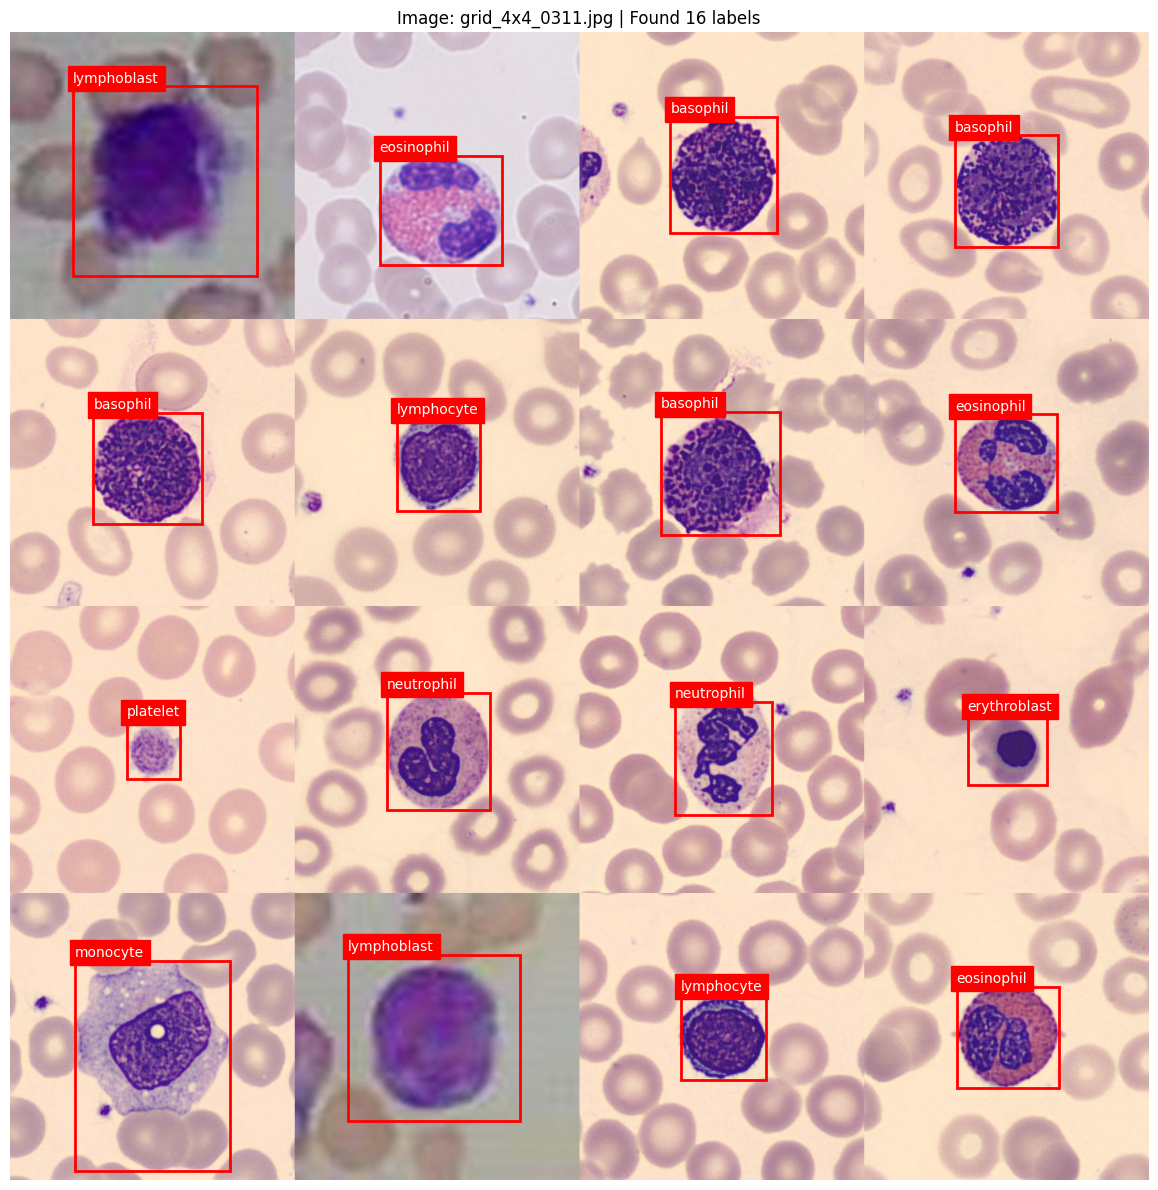

In [9]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define paths
COMBINED_DATASET_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset"
TRAIN_IMG_DIR = os.path.join(COMBINED_DATASET_DIR, "combined_dataset", "train", "images")
TRAIN_LBL_DIR = os.path.join(COMBINED_DATASET_DIR, "combined_dataset", "train", "labels")

# Define class names
CLASS_NAMES = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin',
              'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Get random image
def get_random_image():
    all_images = glob.glob(os.path.join(TRAIN_IMG_DIR, "*.jpg")) + glob.glob(os.path.join(TRAIN_IMG_DIR, "*.png"))
    if not all_images:
        raise Exception(f"No images found in {TRAIN_IMG_DIR}")
    
    random_img_path = random.choice(all_images)
    img_filename = os.path.basename(random_img_path)
    img_basename = os.path.splitext(img_filename)[0]
    label_path = os.path.join(TRAIN_LBL_DIR, f"{img_basename}.txt")
    
    return random_img_path, label_path

# Visualize image with labels
def visualize_with_labels(img_path, label_path):
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    height, width = img.shape[:2]
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    
    # Check if label file exists
    if not os.path.exists(label_path):
        ax.set_title(f"Image without labels: {os.path.basename(img_path)}")
        plt.show()
        return
    
    # Read labels (YOLO format: class_id, x_center, y_center, width, height)
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    # Draw bounding boxes
    for label in labels:
        parts = label.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height
            
            # Calculate top-left corner
            x_min = x_center - (bbox_width / 2)
            y_min = y_center - (bbox_height / 2)
            
            # Get class name
            class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Unknown ({class_id})"
            
            # Add rectangle and label
            rect = Rectangle((x_min, y_min), bbox_width, bbox_height, 
                            linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, class_name, color='white', 
                   backgroundcolor='red', fontsize=10)
    
    ax.set_title(f"Image: {os.path.basename(img_path)} | Found {len(labels)} labels")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the visualization
def main():
    random_img_path, random_label_path = get_random_image()
    print(f"Selected random image: {random_img_path}")
    print(f"Corresponding label file: {random_label_path}")
    
    visualize_with_labels(random_img_path, random_label_path)
    
    # # Print first few lines of the label file
    # if os.path.exists(random_label_path):
    #     with open(random_label_path, 'r') as f:
    #         label_content = f.read()
    #     print("\nLabel file content (first 5 lines):")
    #     for line in label_content.split('\n')[:5]:
    #         print(line)

if __name__ == "__main__":
    main()

## Prediction

Loading background from: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/background.png
Background loaded successfully: (1024, 1024, 3)
Loaded 60 basophil test segments
Loaded 152 eosinophil test segments
Loaded 69 erythroblast test segments
Loaded 138 immunoglobin test segments
Loaded 61 lymphocyte test segments
Loaded 71 monocyte test segments
Loaded 103 neutrophil test segments
Loaded 117 platelet test segments
Loaded 69 lymphoblast test segments
Model loaded successfully from /Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt
Generating test image...
Successfully placed basophil segment
Successfully placed basophil segment
Successfully placed eosinophil segment
Successfully placed eosinophil segment
Successfully placed erythroblast segment
Successfully placed erythroblast segment
Successfully placed immunoglobin segment
Successfully placed immunoglobin segment
Successfully placed lymphocyte segment
Successfully placed lymphocyte segment
Successfully p

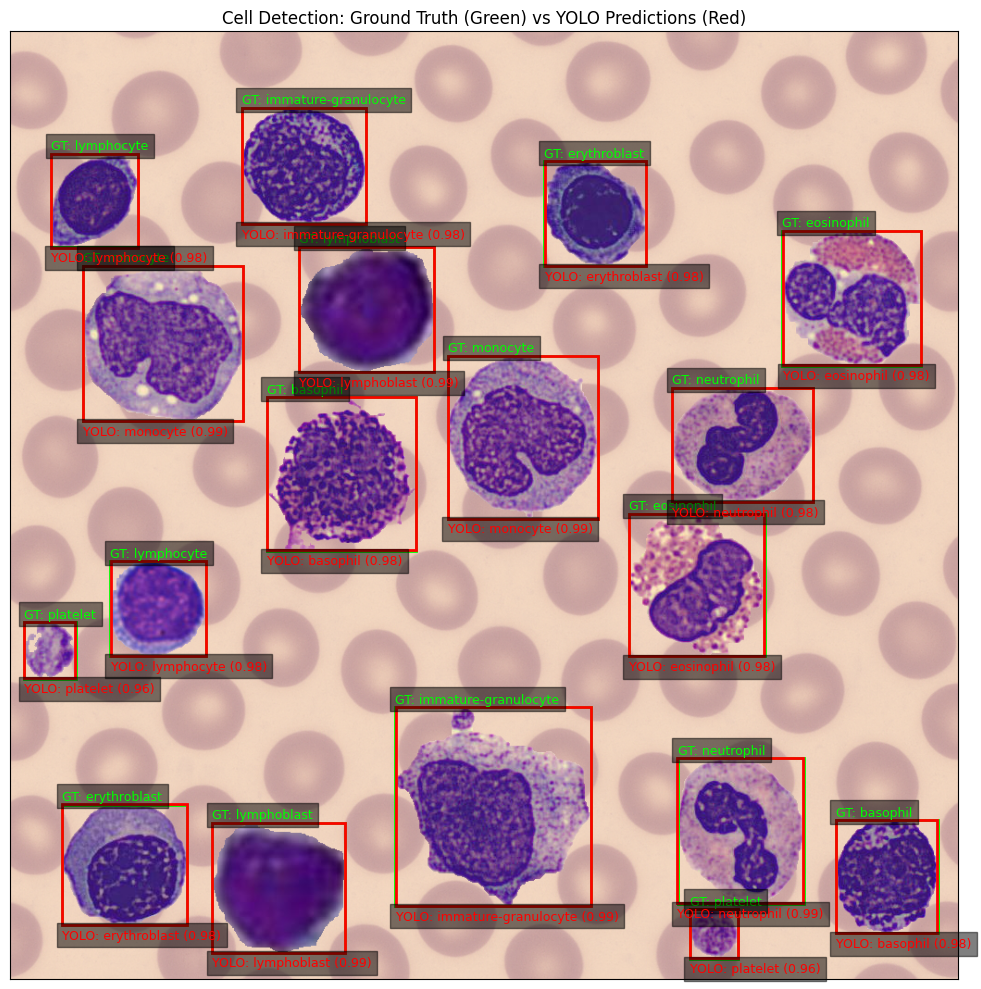

All test results saved to: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/test_results


In [12]:
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
from PIL import Image
from pathlib import Path

# Define paths
OUTPUT_BASE_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments"
TEST_SEGMENTS_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/test/segments"
LABELS_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/test/labels"
BG_PATH = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/background.png"
MODEL_PATH = "/Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt"

# Class names
CLASS_NAMES = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin', 
               'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Define class name corrections mapping
CLASS_NAME_CORRECTIONS = {
    'immunoglobin': 'immature-granulocyte'
}

def check_overlap(new_box, existing_boxes, margin=5):
    """Check if a new box overlaps with any existing boxes."""
    if not existing_boxes:
        return False
        
    new_x1, new_y1, new_x2, new_y2 = new_box
    
    # Add a small margin to prevent cells from being too close
    new_x1 -= margin
    new_y1 -= margin
    new_x2 += margin
    new_y2 += margin
    
    for box in existing_boxes:
        x1, y1, x2, y2 = box
        
        # Check for overlap
        if not (new_x2 < x1 or new_x1 > x2 or new_y2 < y1 or new_y1 > y2):
            return True
    
    return False

def load_test_segments():
    """Load all test segments from the segments directory, organizing by class based on filename."""
    segments = {class_name: [] for class_name in CLASS_NAMES}
    
    # Check if segments directory exists
    if not os.path.exists(TEST_SEGMENTS_DIR):
        print(f"Error: Test segments directory not found: {TEST_SEGMENTS_DIR}")
        return segments
    
    # Load all PNG files from the segments directory
    segment_files = glob.glob(os.path.join(TEST_SEGMENTS_DIR, "*.png"))
    
    for file_path in segment_files:
        # Extract the base filename
        filename = os.path.basename(file_path)
        
        # Extract class name (before the first underscore)
        parts = filename.split('_')
        if parts:
            class_name = parts[0].lower()  # Convert to lowercase to match CLASS_NAMES
            
            # Check if this is a valid class
            if class_name in CLASS_NAMES:
                # Load the segment image
                segment = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
                if segment is not None:
                    segments[class_name].append((segment, file_path))
    
    # Print summary
    for class_name in CLASS_NAMES:
        print(f"Loaded {len(segments[class_name])} {class_name} test segments")
    
    return segments

def place_segments_on_background(background, segments, num_cells_per_class=2):
    """Place test segments on the background without overlap."""
    bg_height, bg_width = background.shape[:2]
    placed_cells = []
    existing_boxes = []
    
    # Make a copy of the background to work with
    result = background.copy()
    
    # Ensure background has proper channels
    if len(result.shape) == 2:  # Grayscale
        result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
    elif result.shape[2] == 4:  # RGBA
        result = cv2.cvtColor(result, cv2.COLOR_BGRA2BGR)
    
    # Try to place segments from each class
    for class_name in CLASS_NAMES:
        if class_name not in segments or not segments[class_name]:
            print(f"Skipping class {class_name}: No segments available")
            continue
            
        # Choose random segments for this class
        available_segments = segments[class_name]
        num_to_place = min(num_cells_per_class, len(available_segments))
        selected_segments = random.sample(available_segments, num_to_place)
        
        for segment, file_path in selected_segments:
            # Check if segment has alpha channel
            if segment is None:
                print(f"Skipping invalid segment: {file_path}")
                continue
                
            if segment.shape[2] == 4:  # RGBA
                seg_height, seg_width = segment.shape[:2]
                
                # Verify segment isn't empty
                if seg_height == 0 or seg_width == 0:
                    print(f"Skipping zero-dimension segment: {file_path}")
                    continue
                
                # Try to find a non-overlapping position
                max_attempts = 50
                found_position = False
                
                for _ in range(max_attempts):
                    # Random position
                    x_pos = random.randint(0, bg_width - seg_width - 1)
                    y_pos = random.randint(0, bg_height - seg_height - 1)
                    
                    # Check for overlap
                    new_box = (x_pos, y_pos, x_pos + seg_width, y_pos + seg_height)
                    if not check_overlap(new_box, existing_boxes):
                        found_position = True
                        existing_boxes.append(new_box)
                        break
                
                if not found_position:
                    print(f"Could not find non-overlapping position for {file_path}")
                    continue
                
                # Check if image regions fit within bounds
                if (y_pos + seg_height > bg_height) or (x_pos + seg_width > bg_width):
                    print(f"Segment placement out of bounds for {file_path}")
                    continue
                
                # Extract alpha channel and blend
                try:
                    alpha = segment[:, :, 3] / 255.0
                    
                    # Create a region of interest on the background
                    roi = result[y_pos:y_pos+seg_height, x_pos:x_pos+seg_width]
                    
                    # Blend the segment with the background based on alpha
                    for c in range(0, 3):
                        roi[:, :, c] = roi[:, :, c] * (1 - alpha) + segment[:, :, c] * alpha
                    
                    # Update the background with the blended ROI
                    result[y_pos:y_pos+seg_height, x_pos:x_pos+seg_width] = roi
                    
                    # Store information about the placed cell
                    placed_cells.append({
                        'class': class_name,
                        'box': [x_pos, y_pos, x_pos + seg_width, y_pos + seg_height],
                        'width': seg_width,
                        'height': seg_height,
                        'file_path': file_path
                    })
                    
                    print(f"Successfully placed {class_name} segment")
                except Exception as e:
                    print(f"Error placing segment {file_path}: {e}")
            else:
                print(f"Skipping segment without alpha channel: {file_path}")
    
    return result, placed_cells

def run_yolo_prediction(image_path, model):
    """Run YOLO prediction on the image."""
    try:
        results = model(image_path)
        return results
    except Exception as e:
        print(f"Error running YOLO prediction: {e}")
        return None

def visualize_with_both_annotations(image, gt_cells, yolo_results):
    """Visualize a single image with both ground truth and predictions."""
    # Convert image to RGB if needed
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 4:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    else:
        image_rgb = image
    
    # Create figure and single axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Display image
    ax.imshow(image_rgb)
    ax.set_title('Cell Detection: Ground Truth (Green) vs YOLO Predictions (Red)')
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw ground truth boxes
    for cell in gt_cells:
        x1, y1, x2, y2 = cell['box']
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        
        # Get correct class name using the mapping
        class_name = cell['class']
        if class_name in CLASS_NAME_CORRECTIONS:
            class_name = CLASS_NAME_CORRECTIONS[class_name]
        
        # Display ground truth class with corrected name
        ax.text(x1, y1-5, f"GT: {class_name}", color='lime', fontsize=9, 
                bbox=dict(facecolor='black', alpha=0.5))
    
    # Process YOLO results
    if yolo_results:
        result = yolo_results[0]
        boxes = result.boxes
        for box in boxes:
            # Get coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = float(box.conf[0])
            cls_id = int(box.cls[0])
            class_name = result.names[cls_id]
            
            # Draw box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y2+15, f"YOLO: {class_name} ({confidence:.2f})", color='red', fontsize=9, 
                    bbox=dict(facecolor='black', alpha=0.5))
    
    plt.tight_layout()
    return fig

def main():
    # Load the background image
    print(f"Loading background from: {BG_PATH}")
    background = cv2.imread(BG_PATH)
    if background is None:
        print(f"Error: Could not load background image from {BG_PATH}")
        return
    else:
        print(f"Background loaded successfully: {background.shape}")
    
    # Load test segments
    test_segments = load_test_segments()
    
    # Create the output directory for test results
    output_dir = os.path.join(OUTPUT_BASE_DIR, "test_results")
    os.makedirs(output_dir, exist_ok=True)
    
    # Load YOLO model
    try:
        model = YOLO(MODEL_PATH)
        print(f"Model loaded successfully from {MODEL_PATH}")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return
    
    print("Generating test image...")
    
    # Place segments on background
    num_cells_per_class = 2  # Fixed number of cells per class for clarity
    result_image, placed_cells = place_segments_on_background(
        background, test_segments, num_cells_per_class
    )
    
    if len(placed_cells) == 0:
        print("Error: No cells were placed on the background!")
        return
    
    # Save the resulting image
    output_image_path = os.path.join(output_dir, "test_image.jpg")
    cv2.imwrite(output_image_path, result_image)
    print(f"Created test image with {len(placed_cells)} cells at {output_image_path}")
    
    # Run YOLO prediction
    yolo_results = run_yolo_prediction(output_image_path, model)
    if yolo_results is None:
        print("Error: YOLO prediction failed!")
        return
    
    # Save YOLO prediction visualization
    yolo_output_path = os.path.join(output_dir, "test_image_yolo.jpg")
    yolo_results[0].save(yolo_output_path)
    print(f"Saved YOLO prediction to {yolo_output_path}")
    
    # Create single image with both ground truth and predictions
    fig = visualize_with_both_annotations(result_image, placed_cells, yolo_results)
    combined_path = os.path.join(output_dir, "test_image_combined.jpg")
    fig.savefig(combined_path)
    print(f"Saved combined visualization to {combined_path}")
    
    # Display the final image with annotations
    plt.show()
    print(f"All test results saved to: {output_dir}")

if __name__ == "__main__":
    main()

## Prediction on other Datasets

Loading model from: /Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt
Model loaded successfully
Running prediction on: /Users/afnanag/Downloads/0678.jpg

image 1/1 /Users/afnanag/Downloads/0678.jpg: 608x1024 2 monocytes, 247.6ms
Speed: 2.2ms preprocess, 247.6ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 1024)


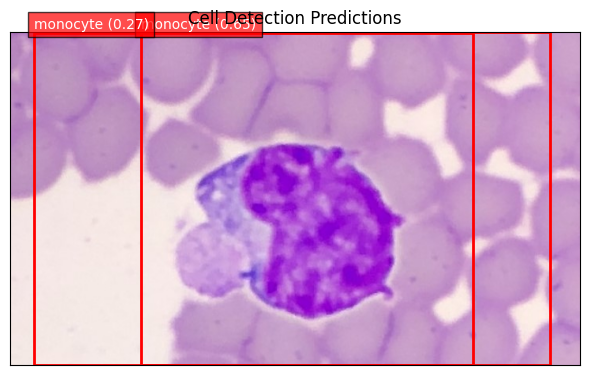

In [26]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO

# Define paths - replace these with your actual paths
MODEL_PATH = "/Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt"  # Replace with your model path
INPUT_IMAGE_PATH = "/Users/afnanag/Downloads/0678.jpg"  # Replace with your image path

def predict_on_image(image_path, model_path):
    """Run YOLO prediction on a single image and display results."""
    print(f"Loading model from: {model_path}")
    try:
        # Load the YOLO model
        model = YOLO(model_path)
        print("Model loaded successfully")
        
        # Check if image exists
        print(f"Running prediction on: {image_path}")
        
        # Run prediction
        results = model(image_path)
        
        if results:
            # Get first result object
            result = results[0]
            
            # Display results
            visualize_predictions(image_path, result)
            
            return results
        else:
            print("No prediction results returned")
            return None
            
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def visualize_predictions(image_path, result):
    """Create a visualization of the predictions."""
    # Load image for display
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(image_rgb)
    ax.set_title('Cell Detection Predictions')
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Get boxes from result
    boxes = result.boxes
    
    # Draw each prediction
    for box in boxes:
        # Get coordinates
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        confidence = float(box.conf[0])
        cls_id = int(box.cls[0])
        class_name = result.names[cls_id]
        
        # Draw box
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Draw label
        ax.text(x1, y1-5, f"{class_name} ({confidence:.2f})", 
                color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.7))
    
    # Show the plot
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run prediction
    predict_on_image(INPUT_IMAGE_PATH, MODEL_PATH)

# YOLOv11 Parameter Testing for Cell Detection

This code implements an extensive testing framework to evaluate how different image transformations affect the performance of a YOLO model trained for blood cell detection. The framework:

1. Places cell segments on a background image
2. Applies various transformations (blur, brightness changes, etc.)
3. Runs YOLOv11 detection on the transformed images
4. Evaluates detection performance with metrics (precision, recall, F1)
5. Visualizes results with comparative analysis

## Key Components

### Test Parameters

The code defines multiple transformation types to test model robustness:

- Original (baseline)
- Grayscale conversion
- Light and heavy Gaussian blur
- Brightness adjustment (increase/decrease)
- Contrast adjustment (increase/decrease)  
- Noise addition
- Scale transformations (up/down)
- Random rotation

### Utility Functions

The code includes helper functions for:
- Loading test segments
- Placing segments on backgrounds
- Alpha blending for transparent images
- Deterministic seed generation
- Image transformations (rotation, grayscale, etc.)
- IoU calculation
- Detection evaluation (precision, recall, F1)

### Robust Testing Methodology

For statistical reliability, the code:
- Runs multiple tests (5 runs) for each parameter
- Uses consistent cell placement across transformations
- Calculates average metrics and standard deviations
- Performs statistical significance testing (t-tests)
- Creates detailed visualizations of results

### Visualization Components

Comprehensive visualizations include:
- Combined ground truth and prediction annotations
- Confusion matrices
- Bar charts comparing transformation performance
- Box plots showing F1 score distributions
- Parameter ranking charts highlighting differences from original

### Statistical Analysis

The code performs statistical analysis to determine:
- Which transformations significantly affect model performance
- Whether transformations perform better or worse than original
- Confidence intervals for performance metrics

The overall approach provides an in-depth evaluation of model robustness against various image transformations with rigorous statistical validation.

In [39]:
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
from PIL import Image
from pathlib import Path
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import copy
import hashlib

# Increase default DPI for matplotlib figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Define paths (using your original paths)
OUTPUT_BASE_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments"
TEST_SEGMENTS_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/test/segments"
LABELS_DIR = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/combined_dataset/combined_dataset/test/labels"
BG_PATH = "/Users/afnanag/projects/DH307/yolov11/grid_and_segments/background.png"
MODEL_PATH = "/Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt"

# Class names
CLASS_NAMES = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin', 
               'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Define class name corrections mapping
CLASS_NAME_CORRECTIONS = {
    'immunoglobin': 'immature-granulocyte'
}

# Define test parameters
TEST_PARAMETERS = {
    'original': {
        'name': 'Original',
        'transform': lambda img: img.copy(),  # Explicit copy to avoid reference issues
    },
    'grayscale': {
        'name': 'Grayscale',
        'transform': lambda img: to_grayscale_with_alpha(img.copy())
        if img.shape[2] == 4 else cv2.cvtColor(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR),
    },
    'blur_light': {
        'name': 'Light Blur',
        'transform': lambda img: cv2.GaussianBlur(img.copy(), (5, 5), 0),
    },
    'blur_heavy': {
        'name': 'Heavy Blur',
        'transform': lambda img: cv2.GaussianBlur(img.copy(), (15, 15), 0),
    },
    'brightness_up': {
        'name': 'Increased Brightness',
        'transform': lambda img: cv2.convertScaleAbs(img.copy(), alpha=1.3, beta=30),
    },
    'brightness_down': {
        'name': 'Decreased Brightness',
        'transform': lambda img: cv2.convertScaleAbs(img.copy(), alpha=0.7, beta=-30),
    },
    'contrast_up': {
        'name': 'Increased Contrast',
        'transform': lambda img: cv2.convertScaleAbs(img.copy(), alpha=1.5, beta=0),
    },
    'contrast_down': {
        'name': 'Decreased Contrast',
        'transform': lambda img: cv2.convertScaleAbs(img.copy(), alpha=0.7, beta=0),
    },
    'noise': {
        'name': 'Added Noise',
        'transform': lambda img: add_noise(img.copy()),
    },
    'scale_down': {
        'name': 'Scale Down (0.8x)',
        'transform': lambda img: cv2.resize(img.copy(), (0, 0), fx=0.8, fy=0.8),
    },
    'scale_up': {
        'name': 'Scale Up (1.2x)',
        'transform': lambda img: cv2.resize(img.copy(), (0, 0), fx=1.2, fy=1.2),
    },
    'rotation': {
        'name': 'Random Rotation',
        'transform': lambda img: rotate_image(img.copy()),
    }
}

def to_grayscale_with_alpha(img):
    """Convert an image to grayscale while preserving alpha channel if present"""
    # Make a deep copy to avoid modifying the original
    img = img.copy()
    
    # If it's RGBA, gray only the first 3 channels, then re-attach alpha
    if img.shape[2] == 4:
        bgr = img[..., :3]
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        alpha = img[..., 3]
        # Stack your gray RGB back with the original alpha
        return np.dstack((gray_bgr, alpha))
    else:
        # fallback for BGR images
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

def add_noise(image, gauss_sigma=30, smooth_ksize=(1,1), poisson_strength=0.1):
    """
    More realistic mixed noise:
      - low-level Gaussian
      - smoothed (spatially correlated)
      - small amount of Poisson
    poisson_strength: fraction of pixels to apply Poisson on [0–1]
    """
    # Make a deep copy to avoid modifying the original
    image = image.copy()
    
    # split alpha if present
    if image.shape[2] == 4:
        alpha = image[:,:,3].copy()
        img = image[:,:,:3].astype(np.float32)
    else:
        img = image.astype(np.float32)
        alpha = None

    # 1) Add smooth Gaussian noise
    gauss = np.random.normal(0, gauss_sigma, img.shape).astype(np.float32)
    gauss = cv2.GaussianBlur(gauss, smooth_ksize, 0)
    noisy = img + gauss

    # 2) Clip and convert to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    # 3) Poisson shot noise on a random subset of pixels
    if poisson_strength > 0:
        mask = (np.random.rand(*noisy.shape[:2]) < poisson_strength)
        # scale to [0,1], sample Poisson, back to 0–255
        norm = noisy.astype(np.float32) / 255.0
        shot = np.random.poisson(norm * 255.0) / 255.0
        shot = np.clip(shot * 255.0, 0, 255).astype(np.uint8)
        # blend
        noisy[mask] = shot[mask]

    # 4) reattach alpha
    if alpha is not None:
        out = cv2.cvtColor(noisy, cv2.COLOR_BGR2BGRA)
        out[:,:,3] = alpha
        return out
    else:
        return noisy

def generate_deterministic_seed(key, base_seed=42):
    """Generate a deterministic but different seed for each key"""
    # Create a hash of the key and use it to modify the base seed
    key_hash = int(hashlib.md5(key.encode()).hexdigest(), 16) % 10000
    return base_seed + key_hash

def rotate_image(image, deterministic_angle=None):
    """Rotate an image by a random angle between -45 and 45 degrees or by specified angle"""
    if image is None:
        return None
    
    # Make a deep copy to avoid modifying the original
    image = image.copy()
    
    # Use deterministic angle if provided, otherwise random
    angle = deterministic_angle if deterministic_angle is not None else random.uniform(-45, 45)
    
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Define border value based on image type
    border = (0, 0, 0, 0) if image.shape[2] == 4 else (0, 0, 0)
    
    return cv2.warpAffine(image, M, (width, height), flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=border)

def check_overlap(new_box, existing_boxes, margin=5):
    """Check if a new box overlaps with any existing boxes"""
    if not existing_boxes:
        return False
    x1, y1, x2, y2 = new_box
    x1 -= margin; y1 -= margin; x2 += margin; y2 += margin
    for bx1, by1, bx2, by2 in existing_boxes:
        if not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2):
            return True
    return False

def load_test_segments():
    """Load all test segment images from the specified directory"""
    segments = {cls: [] for cls in CLASS_NAMES}
    if not os.path.exists(TEST_SEGMENTS_DIR):
        print(f"Error: Test segments directory not found: {TEST_SEGMENTS_DIR}")
        return segments
    
    for fp in glob.glob(os.path.join(TEST_SEGMENTS_DIR, "*.png")):
        fn = os.path.basename(fp)
        parts = fn.split('_')
        if parts:
            cls = parts[0].lower()
            if cls in CLASS_NAMES:
                seg = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
                if seg is not None:
                    segments[cls].append((seg, fp))
    
    for cls in CLASS_NAMES:
        print(f"Loaded {len(segments[cls])} {cls} test segments")
    return segments

def place_segments_on_background(background, segments, num_cells_per_class=2, transform_key='original', 
                                placement_seed=None, transform_seed=None, 
                                save_transformed_segments_dir=None):
    """
    Place cell segments on the background image
    
    Args:
        background: Background image
        segments: Dictionary of cell segments
        num_cells_per_class: Number of cells per class to place
        transform_key: Key indicating which transformation to apply
        placement_seed: Seed for random placement (for reproducibility)
        transform_seed: Seed for random transformations (for reproducibility)
        save_transformed_segments_dir: Directory to save transformed segments for inspection
    """
    # Set seeds if provided
    if placement_seed is not None:
        random.seed(placement_seed)
        np.random.seed(placement_seed)
        
    # Make a copy of the background
    bg = background.copy()
    if len(bg.shape) == 2:
        bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR)
    elif bg.shape[2] == 4:
        bg = cv2.cvtColor(bg, cv2.COLOR_BGRA2BGR)
    
    h, w = bg.shape[:2]
    placed, boxes = [], []
    transform = TEST_PARAMETERS[transform_key]['transform']
    
    # If requested, create directory for saving transformed segments
    if save_transformed_segments_dir:
        os.makedirs(save_transformed_segments_dir, exist_ok=True)
    
    # Set transform seed if provided (for deterministic transformations like rotation)
    if transform_seed is not None:
        # This is still not ideal as it only affects numpy-based randomness
        # For full determinism, we'd need to modify any randomness in the transform functions
        np.random.seed(transform_seed)
        random.seed(transform_seed)
    
    # Create a deterministic angle for rotation (if applicable)
    rotation_angle = random.uniform(-45, 45) if transform_key == 'rotation' else None
    
    for cls in CLASS_NAMES:
        if cls not in segments or not segments[cls]:
            continue
            
        # Select segments for this class
        sel = random.sample(segments[cls], min(num_cells_per_class, len(segments[cls])))
        
        for i, (seg, fp) in enumerate(sel):
            if seg is None or seg.shape[2] == 0:
                continue
                
            # Apply the transformation
            if transform_key == 'rotation' and rotation_angle is not None:
                # Use the pre-determined angle for rotation
                ts = rotate_image(seg.copy(), rotation_angle)
            else:
                ts = transform(seg.copy())
                
            if ts is None:
                continue
                
            # Save transformed segment for inspection if requested
            if save_transformed_segments_dir:
                filename = f"{transform_key}_{cls}_{i}.png"
                cv2.imwrite(os.path.join(save_transformed_segments_dir, filename), ts)
            
            sh, sw = ts.shape[:2]
            if sh == 0 or sw == 0:
                continue
                
            # Try to find a non-overlapping position
            found = False
            for _ in range(50):
                x = random.randint(0, w-sw-1)
                y = random.randint(0, h-sh-1)
                nb = (x, y, x+sw, y+sh)
                if not check_overlap(nb, boxes):
                    boxes.append(nb)
                    found = True
                    break
                    
            if not found:
                continue
                
            if y+sh > h or x+sw > w:
                continue
                
            # Handle alpha channel blending
            alpha = ts[:,:,3]/255.0 if ts.shape[2] == 4 else None
            roi = bg[y:y+sh, x:x+sw]
            
            if alpha is not None:
                if roi.shape[:2] != alpha.shape:
                    ts = cv2.resize(ts, (roi.shape[1], roi.shape[0]))
                    alpha = cv2.resize(alpha[...,None], (roi.shape[1], roi.shape[0]))[:,:,0]
                
                for c in range(3):
                    roi[:,:,c] = roi[:,:,c]*(1-alpha) + ts[:,:,c]*alpha
                    
                bg[y:y+sh, x:x+sw] = roi
                
            placed.append({
                'class': cls,
                'box': [x, y, x+sw, y+sh],
                'width': sw,
                'height': sh,
                'file_path': fp
            })
            
    return bg, placed

def run_yolo_prediction(image_path, model):
    """Run YOLO prediction on an image"""
    try:
        return model(image_path)
    except Exception as e:
        print(f"Error running YOLO prediction: {e}")
        return None

def calculate_iou(box1, box2):
    """Calculate IoU between two bounding boxes"""
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2
    
    # Calculate intersection coordinates
    xL, yT = max(x11, x12), max(y11, y12)
    xR, yB = min(x21, x22), min(y21, y22)
    
    # Check if boxes overlap
    if xR < xL or yB < yT:
        return 0.0
        
    # Calculate areas
    inter = (xR-xL)*(yB-yT)
    area1 = (x21-x11)*(y21-y11)
    area2 = (x22-x12)*(y22-y12)
    union = area1 + area2 - inter
    
    return inter/union if union > 0 else 0.0

def evaluate_detection(gt_cells, yolo_results, iou_threshold=0.5):
    """Evaluate detection results against ground truth"""
    if not yolo_results:
        return {
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'class_metrics': {cls: {'tp': 0, 'fp': 0, 'fn': 0} for cls in CLASS_NAMES},
            'confusion_matrix': None
        }
        
    res = yolo_results[0]
    class_metrics = {cls: {'tp': 0, 'fp': 0, 'fn': 0} for cls in CLASS_NAMES}
    matched = [False] * len(gt_cells)
    y_true, y_pred = [], []
    
    if hasattr(res, 'boxes') and len(res.boxes) > 0:
        for box in res.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_id = int(box.cls[0])
            pred = res.names[cls_id]
            
            # Find best matching ground truth box
            best_iou, bm = 0, -1
            for i, gt in enumerate(gt_cells):
                if matched[i]:
                    continue
                    
                gt_cls = CLASS_NAME_CORRECTIONS.get(gt['class'], gt['class'])
                iou = calculate_iou([x1, y1, x2, y2], gt['box'])
                
                if iou > best_iou and iou >= iou_threshold:
                    best_iou, bm = iou, i
                    
            if bm >= 0:
                # We have a match
                true_cls = gt_cells[bm]['class']
                true_cls_corr = CLASS_NAME_CORRECTIONS.get(true_cls, true_cls)
                
                if pred == true_cls_corr:
                    class_metrics[true_cls]['tp'] += 1
                else:
                    class_metrics[true_cls]['fn'] += 1
                    # Only count as FP if it's one of our classes
                    if pred in class_metrics:
                        class_metrics[pred]['fp'] += 1
                    else:
                        # Default to first class if unknown
                        class_metrics[CLASS_NAMES[0]]['fp'] += 1
                        
                y_true.append(true_cls_corr)
                y_pred.append(pred)
                matched[bm] = True
            else:
                # False positive
                if pred in class_metrics:
                    class_metrics[pred]['fp'] += 1
                else:
                    class_metrics[CLASS_NAMES[0]]['fp'] += 1
                    
                y_true.append('background')
                y_pred.append(pred)
                
    # Count unmatched ground truth as false negatives
    for i, m in enumerate(matched):
        if not m:
            gt_cls = gt_cells[i]['class']
            class_metrics[gt_cls]['fn'] += 1
            y_true.append(gt_cls)
            y_pred.append('missed')
            
    # Calculate overall metrics
    tp = sum(m['tp'] for m in class_metrics.values())
    fp = sum(m['fp'] for m in class_metrics.values())
    fn = sum(m['fn'] for m in class_metrics.values())
    
    prec = tp/(tp+fp) if tp+fp > 0 else 0
    rec = tp/(tp+fn) if tp+fn > 0 else 0
    f1 = 2*prec*rec/(prec+rec) if prec+rec > 0 else 0
    
    # Calculate confusion matrix
    all_cls = sorted(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=all_cls) if len(all_cls) > 1 else None
    
    return {
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'class_metrics': class_metrics,
        'confusion_matrix': (cm, all_cls) if cm is not None else None
    }

def visualize_with_both_annotations(image, gt_cells, yolo_results, transform_name='Original'):
    """Create visualization with both ground truth and prediction annotations"""
    if image.shape[2] == 3:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif image.shape[2] == 4:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    else:
        img_rgb = image
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.imshow(img_rgb)
    ax.set_title(f'Cell Detection with {transform_name}: Ground Truth (Green) vs YOLO Predictions (Red)')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw ground truth boxes
    for cell in gt_cells:
        x1, y1, x2, y2 = cell['box']
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        cls = CLASS_NAME_CORRECTIONS.get(cell['class'], cell['class'])
        ax.text(x1, y1-5, f"GT: {cls}", color='lime', fontsize=9, bbox=dict(facecolor='black', alpha=0.5))
    
    # Draw prediction boxes
    if yolo_results:
        res = yolo_results[0]
        for box in res.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls = res.names[cls_id]
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y2+15, f"YOLO: {cls} ({conf:.2f})", color='red', fontsize=9, bbox=dict(facecolor='black', alpha=0.5))
    
    plt.tight_layout()
    return fig

def visualize_confusion_matrix(confusion_matrix_data, output_path):
    """Visualize confusion matrix and save to file"""
    if confusion_matrix_data is None:
        return
        
    cm, classes = confusion_matrix_data
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def run_parameter_tests(num_runs=5):
    """
    Run parameter tests with multiple runs per parameter for more reliable results
    
    Args:
        num_runs: Number of runs per parameter to average results
    """
    print(f"Loading background from: {BG_PATH}")
    background = cv2.imread(BG_PATH)
    if background is None:
        print(f"Error: Could not load background image from {BG_PATH}")
        return
        
    test_segments = load_test_segments()
    output_dir = os.path.join(OUTPUT_BASE_DIR, "parameter_test_results_fixed")
    os.makedirs(output_dir, exist_ok=True)
    
    # Create directory for transformed segments inspection
    transformed_segments_dir = os.path.join(output_dir, "transformed_segments")
    os.makedirs(transformed_segments_dir, exist_ok=True)
    
    try:
        model = YOLO(MODEL_PATH)
        print(f"Model loaded successfully from {MODEL_PATH}")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return
        
    # Initialize summary data for multiple runs
    all_runs_results = []
    
    # Run the tests multiple times with different seeds
    for run_idx in range(num_runs):
        print(f"\n===== Starting Run {run_idx+1}/{num_runs} =====")
        
        # Generate a master seed for this run
        master_seed = 42 + run_idx * 100
        
        # Generate consistent placement positions across all tests for this run
        # This ensures fair comparison - all transformations will place cells in same positions
        placements = {}
        
        # First generate all cell placements with fixed positions
        placement_seed = master_seed
        random.seed(placement_seed)
        np.random.seed(placement_seed)
        
        # Create a reference layout with original cells
        reference_bg, reference_cells = place_segments_on_background(
            background, test_segments, num_cells_per_class=3, transform_key='original')
            
        if not reference_cells:
            print(f"Error: No cells were placed in the reference layout for run {run_idx+1}")
            continue
            
        # Test each parameter while keeping the exact same cell positions
        test_results = []
        for key, info in tqdm(TEST_PARAMETERS.items(), desc=f"Run {run_idx+1} tests"):
            print(f"\nTesting with {info['name']} transformation...")
            
            # Create directory for this test
            test_output_dir = os.path.join(output_dir, f"run{run_idx+1}_{key}")
            os.makedirs(test_output_dir, exist_ok=True)
            
            # Create directory for transformed segments for this test
            test_transform_dir = os.path.join(transformed_segments_dir, f"run{run_idx+1}_{key}")
            
            # Set deterministic seeds for transformations
            transform_seed = generate_deterministic_seed(f"{key}_{run_idx}")
            
            # Apply transformations to segments based on reference cells
            result_image = background.copy()
            if len(result_image.shape) == 2:
                result_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2BGR)
            elif result_image.shape[2] == 4:
                result_image = cv2.cvtColor(result_image, cv2.COLOR_BGRA2BGR)
                
            # Apply transformations to reference cells
            placed_cells = []
            transform = TEST_PARAMETERS[key]['transform']
            
            # Set transform seed for deterministic transformations
            random.seed(transform_seed)
            np.random.seed(transform_seed)
            
            # For rotation, pregenerate a fixed angle
            rotation_angle = random.uniform(-45, 45) if key == 'rotation' else None
            
            for ref_cell in reference_cells:
                cls = ref_cell['class']
                x, y, x2, y2 = ref_cell['box']
                w, h = ref_cell['width'], ref_cell['height']
                
                # Load the original segment
                orig_seg = cv2.imread(ref_cell['file_path'], cv2.IMREAD_UNCHANGED)
                
                if orig_seg is None:
                    continue
                    
                # Apply the transformation
                if key == 'rotation' and rotation_angle is not None:
                    # Use the pre-determined angle for rotation
                    ts = rotate_image(orig_seg.copy(), rotation_angle)
                else:
                    ts = transform(orig_seg.copy())
                    
                if ts is None:
                    continue
                    
                # Save transformed segment for inspection
                if key != 'original':  # Only save non-original segments
                    filename = f"{key}_{cls}_{len(placed_cells)}.png"
                    os.makedirs(test_transform_dir, exist_ok=True)
                    cv2.imwrite(os.path.join(test_transform_dir, filename), ts)
                
                # Get new dimensions after transformation
                sh, sw = ts.shape[:2]
                
                # Skip if transformation resulted in invalid dimensions
                if sh == 0 or sw == 0:
                    continue
                    
                # Calculate placement position to center the cell
                x_center = x + w//2
                y_center = y + h//2
                new_x = max(0, min(x_center - sw//2, result_image.shape[1] - sw))
                new_y = max(0, min(y_center - sh//2, result_image.shape[0] - sh))
                
                # Update the cell info with new dimensions
                placed_cells.append({
                    'class': cls,
                    'box': [new_x, new_y, new_x + sw, new_y + sh],
                    'width': sw,
                    'height': sh,
                    'file_path': ref_cell['file_path']
                })
                
                # Alpha blending
                alpha = ts[:,:,3]/255.0 if ts.shape[2] == 4 else None
                
                # Ensure the region is within image bounds
                if new_y + sh > result_image.shape[0] or new_x + sw > result_image.shape[1]:
                    continue
                    
                roi = result_image[new_y:new_y+sh, new_x:new_x+sw]
                
                if alpha is not None:
                    # Resize if dimensions don't match
                    if roi.shape[:2] != alpha.shape:
                        ts = cv2.resize(ts, (roi.shape[1], roi.shape[0]))
                        alpha = cv2.resize(alpha[...,None], (roi.shape[1], roi.shape[0]))[:,:,0]
                    
                    # Apply alpha blending
                    for c in range(3):
                        roi[:,:,c] = roi[:,:,c]*(1-alpha) + ts[:,:,c]*alpha
                        
                    result_image[new_y:new_y+sh, new_x:new_x+sw] = roi
                    
            # Save the constructed test image
            output_image_path = os.path.join(test_output_dir, f"{key}_test_image.jpg")
            cv2.imwrite(output_image_path, result_image, [cv2.IMWRITE_JPEG_QUALITY, 95])
            
            # Run YOLO prediction
            yolo_results = run_yolo_prediction(output_image_path, model)
            if yolo_results is None:
                print(f"Error: YOLO prediction failed for {info['name']}")
                continue
                
            # Save YOLO result visualization
            yolo_output_path = os.path.join(test_output_dir, f"{key}_yolo_result.jpg")
            yolo_results[0].save(yolo_output_path)
            
            # Evaluate detection performance
            metrics = evaluate_detection(placed_cells, yolo_results)
            
            # Save metrics
            metrics_path = os.path.join(test_output_dir, f"{key}_metrics.txt")
            with open(metrics_path, 'w') as f:
                f.write(f"Run: {run_idx+1}/{num_runs}\n")
                f.write(f"Overall Precision: {metrics['precision']:.4f}\n")
                f.write(f"Overall Recall: {metrics['recall']:.4f}\n")
                f.write(f"Overall F1 Score: {metrics['f1_score']:.4f}\n\n")
                f.write("Class-wise Metrics:\n")
                for cls, m in metrics['class_metrics'].items():
                    p = m['tp']/(m['tp']+m['fp']) if (m['tp']+m['fp']) > 0 else 0
                    r = m['tp']/(m['tp']+m['fn']) if (m['tp']+m['fn']) > 0 else 0
                    f1s = 2*p*r/(p+r) if (p+r) > 0 else 0
                    f.write(f"  {cls}:\n")
                    f.write(f"    TP: {m['tp']}, FP: {m['fp']}, FN: {m['fn']}\n")
                    f.write(f"    Precision: {p:.4f}\n")
                    f.write(f"    Recall: {r:.4f}\n")
                    f.write(f"    F1 Score: {f1s:.4f}\n")
            
            # Create confusion matrix visualization
            if metrics['confusion_matrix'] is not None:
                cm_path = os.path.join(test_output_dir, f"{key}_confusion_matrix.jpg")
                visualize_confusion_matrix(metrics['confusion_matrix'], cm_path)
                
            # Create combined visualization
            fig = visualize_with_both_annotations(result_image, placed_cells, yolo_results, info['name'])
            combined_path = os.path.join(test_output_dir, f"{key}_combined_visualization.jpg")
            fig.savefig(combined_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            
            # Save results for this test
            test_results.append({
                'test_key': key,
                'test_name': info['name'],
                'run': run_idx + 1,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'num_cells': len(placed_cells),
                'num_detections': len(yolo_results[0].boxes) if yolo_results and hasattr(yolo_results[0], 'boxes') else 0
            })
            
            print(f"Completed test for {info['name']} - F1 Score: {metrics['f1_score']:.4f}")
            
        # Add results for this run to overall results
        all_runs_results.extend(test_results)
        
        # Create a summary for this run
        run_summary_df = pd.DataFrame(test_results)
        run_summary_path = os.path.join(output_dir, f"run{run_idx+1}_summary.csv")
        run_summary_df.to_csv(run_summary_path, index=False)
        
        # Create visualization for this run
        plt.figure(figsize=(16, 12), dpi=300)
        
        plt.subplot(1, 3, 1)
        plt.bar(run_summary_df['test_name'], run_summary_df['f1_score'])
        plt.xticks(rotation=90)
        plt.title(f'Run {run_idx+1} - F1 Score by Parameter')
        plt.ylim(0, 1)
        
        plt.subplot(1, 3, 2)
        plt.bar(run_summary_df['test_name'], run_summary_df['precision'])
        plt.xticks(rotation=90)
        plt.title(f'Run {run_idx+1} - Precision by Parameter')
        plt.ylim(0, 1)
        
        plt.subplot(1, 3, 3)
        plt.bar(run_summary_df['test_name'], run_summary_df['recall'])
        plt.xticks(rotation=90)
        plt.title(f'Run {run_idx+1} - Recall by Parameter')
        plt.ylim(0, 1)
        
        run_viz_path = os.path.join(output_dir, f"run{run_idx+1}_summary_plot.jpg")
        plt.tight_layout()
        plt.savefig(run_viz_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        # Display best and worst for this run
        best = run_summary_df.loc[run_summary_df['f1_score'].idxmax()]
        worst = run_summary_df.loc[run_summary_df['f1_score'].idxmin()]
        print(f"\nRun {run_idx+1} Results Summary:")
        print(f"Best parameter: {best['test_name']} (F1 Score: {best['f1_score']:.4f})")
        print(f"Worst parameter: {worst['test_name']} (F1 Score: {worst['f1_score']:.4f})")
    
    # Create overall summary across all runs
    all_runs_df = pd.DataFrame(all_runs_results)
    
    # Save detailed results
    all_runs_path = os.path.join(output_dir, "all_runs_results.csv")
    all_runs_df.to_csv(all_runs_path, index=False)
    
    # Calculate average metrics per test across all runs
    avg_results = all_runs_df.groupby('test_key').agg({
        'test_name': 'first',  # Just get the name
        'precision': 'mean',
        'recall': 'mean',
        'f1_score': 'mean',
        'num_cells': 'mean',
        'num_detections': 'mean'
    }).reset_index()
    
    # Calculate standard deviation for confidence intervals
    std_results = all_runs_df.groupby('test_key').agg({
        'precision': 'std',
        'recall': 'std',
        'f1_score': 'std'
    }).reset_index()
    
    # Merge the average and std dataframes
    avg_results['precision_std'] = std_results['precision']
    avg_results['recall_std'] = std_results['recall']
    avg_results['f1_score_std'] = std_results['f1_score']
    
    # Save average results
    avg_results_path = os.path.join(output_dir, "average_results.csv")
    avg_results.to_csv(avg_results_path, index=False)
    
    # Create sorted dataframe for visualization
    sorted_avg = avg_results.sort_values('f1_score', ascending=False)
    
    # Create summary visualization with error bars
    plt.figure(figsize=(16, 12), dpi=300)
    
    # F1 Score with error bars
    plt.subplot(1, 3, 1)
    plt.bar(sorted_avg['test_name'], sorted_avg['f1_score'], yerr=sorted_avg['f1_score_std'])
    plt.xticks(rotation=90)
    plt.title('Average F1 Score by Parameter (with std dev)')
    plt.ylim(0, 1)
    
    # Precision with error bars
    plt.subplot(1, 3, 2)
    plt.bar(sorted_avg['test_name'], sorted_avg['precision'], yerr=sorted_avg['precision_std'])
    plt.xticks(rotation=90)
    plt.title('Average Precision by Parameter (with std dev)')
    plt.ylim(0, 1)
    
    # Recall with error bars
    plt.subplot(1, 3, 3)
    plt.bar(sorted_avg['test_name'], sorted_avg['recall'], yerr=sorted_avg['recall_std'])
    plt.xticks(rotation=90)
    plt.title('Average Recall by Parameter (with std dev)')
    plt.ylim(0, 1)
    
    summary_viz_path = os.path.join(output_dir, "overall_summary_plot.jpg")
    plt.tight_layout()
    plt.savefig(summary_viz_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create detailed comparison boxplot
    plt.figure(figsize=(16, 10), dpi=300)
    sns.boxplot(x='test_name', y='f1_score', data=all_runs_df)
    plt.xticks(rotation=90)
    plt.title('F1 Score Distribution by Parameter')
    plt.tight_layout()
    boxplot_path = os.path.join(output_dir, "f1_score_boxplot.jpg")
    plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create ranking visualization showing original vs others
    # Sort parameters by average F1 score
    sorted_by_f1 = avg_results.sort_values('f1_score', ascending=False)
    
    # Plot showing original vs others
    plt.figure(figsize=(14, 8), dpi=300)
    bars = plt.bar(sorted_by_f1['test_name'], sorted_by_f1['f1_score'], yerr=sorted_by_f1['f1_score_std'])
    
    # Highlight the original in a different color
    for i, name in enumerate(sorted_by_f1['test_name']):
        if name == 'Original':
            bars[i].set_color('gold')
            
    plt.xticks(rotation=90)
    plt.title('Average F1 Score by Parameter (Original highlighted)')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    ranking_path = os.path.join(output_dir, "parameter_ranking.jpg")
    plt.savefig(ranking_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Calculate statistical significance
    print("\n=== Statistical Analysis ===")
    try:
        from scipy import stats
        
        # Get original performance across runs
        original_perf = all_runs_df[all_runs_df['test_key'] == 'original']['f1_score'].values
        
        # Compare each transformation against original
        sig_results = []
        for key in sorted_by_f1['test_key']:
            if key == 'original':
                continue
                
            transform_perf = all_runs_df[all_runs_df['test_key'] == key]['f1_score'].values
            t_stat, p_value = stats.ttest_ind(original_perf, transform_perf)
            sig_results.append({
                'test_key': key,
                'test_name': TEST_PARAMETERS[key]['name'],
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'vs_original': 'Better' if transform_perf.mean() > original_perf.mean() else 'Worse'
            })
            
        # Save statistical results
        sig_df = pd.DataFrame(sig_results)
        sig_path = os.path.join(output_dir, "statistical_analysis.csv")
        sig_df.to_csv(sig_path, index=False)
        
        # Print significant results
        sig_only = sig_df[sig_df['significant']]
        if len(sig_only) > 0:
            print("\nStatistically significant differences from original:")
            for _, row in sig_only.iterrows():
                print(f"- {row['test_name']}: {row['vs_original']} (p={row['p_value']:.4f})")
        else:
            print("\nNo statistically significant differences from original were found.")
            
    except ImportError:
        print("SciPy not available. Skipping statistical significance tests.")
        
    # Display best and worst overall
    best = sorted_by_f1.iloc[0]
    worst = sorted_by_f1.iloc[-1]
    original = avg_results[avg_results['test_key'] == 'original'].iloc[0]
    
    print("\nOverall Results Summary:")
    print(f"Best parameter: {best['test_name']} (F1 Score: {best['f1_score']:.4f} ± {best['f1_score_std']:.4f})")
    print(f"Worst parameter: {worst['test_name']} (F1 Score: {worst['f1_score']:.4f} ± {worst['f1_score_std']:.4f})")
    print(f"Original performance: F1 Score: {original['f1_score']:.4f} ± {original['f1_score_std']:.4f}")
    print(f"\nAll parameter tests completed. Results saved to: {output_dir}")
    print(f"Summary report available at: {avg_results_path}")
    print(f"Summary visualization available at: {summary_viz_path}")
    print(f"Parameter ranking visualization: {ranking_path}")
    
    # Return the results dataframes for further analysis if needed
    return {
        'all_runs': all_runs_df,
        'average_results': avg_results
    }

if __name__ == "__main__":
    # Run the improved parameter tests with 5 runs per parameter
    run_parameter_tests(num_runs=5)
                

Loading background from: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/background.png
Loaded 60 basophil test segments
Loaded 152 eosinophil test segments
Loaded 69 erythroblast test segments
Loaded 138 immunoglobin test segments
Loaded 61 lymphocyte test segments
Loaded 71 monocyte test segments
Loaded 103 neutrophil test segments
Loaded 117 platelet test segments
Loaded 69 lymphoblast test segments
Model loaded successfully from /Users/afnanag/projects/DH307/yolov11/runs/detect/train12/weights/best.pt

===== Starting Run 1/5 =====


Run 1 tests:   0%|          | 0/12 [00:00<?, ?it/s]


Testing with Original transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_original/original_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 4 lymphocytes, 3 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 594.5ms
Speed: 2.6ms preprocess, 594.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:   8%|▊         | 1/12 [00:01<00:14,  1.34s/it]

Completed test for Original - F1 Score: 0.9434

Testing with Grayscale transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_grayscale/grayscale_test_image.jpg: 1024x1024 17 erythroblasts, 22 lymphoblasts, 615.5ms
Speed: 2.2ms preprocess, 615.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  17%|█▋        | 2/12 [00:02<00:13,  1.32s/it]

Completed test for Grayscale - F1 Score: 0.1231

Testing with Light Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_blur_light/blur_light_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 4 lymphocytes, 2 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 569.8ms
Speed: 2.3ms preprocess, 569.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  25%|██▌       | 3/12 [00:03<00:11,  1.27s/it]

Completed test for Light Blur - F1 Score: 0.9615

Testing with Heavy Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_blur_heavy/blur_heavy_test_image.jpg: 1024x1024 1 basophil, 3 eosinophils, 4 erythroblasts, 5 immature-granulocytes, 4 lymphocytes, 2 monocytes, 3 neutrophils, 6 platelets, 2 lymphoblasts, 581.2ms
Speed: 2.4ms preprocess, 581.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  33%|███▎      | 4/12 [00:05<00:10,  1.26s/it]

Completed test for Heavy Blur - F1 Score: 0.7500

Testing with Increased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_brightness_up/brightness_up_test_image.jpg: 1024x1024 3 basophils, 6 eosinophils, 3 erythroblasts, 6 immature-granulocytes, 3 lymphocytes, 3 monocytes, 3 platelets, 2 lymphoblasts, 563.3ms
Speed: 3.0ms preprocess, 563.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  42%|████▏     | 5/12 [00:06<00:09,  1.32s/it]

Completed test for Increased Brightness - F1 Score: 0.8364

Testing with Decreased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_brightness_down/brightness_down_test_image.jpg: 1024x1024 4 basophils, 5 eosinophils, 3 erythroblasts, 9 immature-granulocytes, 1 monocyte, 3 neutrophils, 3 platelets, 2 lymphoblasts, 534.0ms
Speed: 3.2ms preprocess, 534.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  50%|█████     | 6/12 [00:07<00:07,  1.30s/it]

Completed test for Decreased Brightness - F1 Score: 0.7143

Testing with Increased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_contrast_up/contrast_up_test_image.jpg: 1024x1024 3 basophils, 6 eosinophils, 3 erythroblasts, 6 immature-granulocytes, 3 lymphocytes, 3 monocytes, 3 platelets, 2 lymphoblasts, 533.3ms
Speed: 2.9ms preprocess, 533.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  58%|█████▊    | 7/12 [00:09<00:06,  1.27s/it]

Completed test for Increased Contrast - F1 Score: 0.8364

Testing with Decreased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_contrast_down/contrast_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 6 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 564.7ms
Speed: 2.3ms preprocess, 564.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  67%|██████▋   | 8/12 [00:10<00:05,  1.27s/it]

Completed test for Decreased Contrast - F1 Score: 0.8889

Testing with Added Noise transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_noise/noise_test_image.jpg: 1024x1024 4 erythroblasts, 21 immature-granulocytes, 2 platelets, 606.4ms
Speed: 3.8ms preprocess, 606.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  75%|███████▌  | 9/12 [00:11<00:03,  1.32s/it]

Completed test for Added Noise - F1 Score: 0.2642

Testing with Scale Down (0.8x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_scale_down/scale_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 539.9ms
Speed: 3.3ms preprocess, 539.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  83%|████████▎ | 10/12 [00:12<00:02,  1.28s/it]

Completed test for Scale Down (0.8x) - F1 Score: 1.0000

Testing with Scale Up (1.2x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_scale_up/scale_up_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 2 lymphocytes, 3 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 599.6ms
Speed: 2.8ms preprocess, 599.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests:  92%|█████████▏| 11/12 [00:14<00:01,  1.31s/it]

Completed test for Scale Up (1.2x) - F1 Score: 0.8235

Testing with Random Rotation transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run1_rotation/rotation_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 571.7ms
Speed: 33.3ms preprocess, 571.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 1 tests: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Completed test for Random Rotation - F1 Score: 0.9615



Run 1 Results Summary:
Best parameter: Scale Down (0.8x) (F1 Score: 1.0000)
Worst parameter: Grayscale (F1 Score: 0.1231)

===== Starting Run 2/5 =====


Run 2 tests:   0%|          | 0/12 [00:00<?, ?it/s]


Testing with Original transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_original/original_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 589.9ms
Speed: 3.1ms preprocess, 589.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:   8%|▊         | 1/12 [00:01<00:13,  1.26s/it]

Completed test for Original - F1 Score: 1.0000

Testing with Grayscale transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_grayscale/grayscale_test_image.jpg: 1024x1024 15 erythroblasts, 19 lymphoblasts, 622.9ms
Speed: 3.1ms preprocess, 622.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  17%|█▋        | 2/12 [00:02<00:12,  1.27s/it]

Completed test for Grayscale - F1 Score: 0.0702

Testing with Light Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_blur_light/blur_light_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 651.6ms
Speed: 2.8ms preprocess, 651.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  25%|██▌       | 3/12 [00:03<00:11,  1.27s/it]

Completed test for Light Blur - F1 Score: 1.0000

Testing with Heavy Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_blur_heavy/blur_heavy_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 4 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 4 platelets, 1 lymphoblast, 595.0ms
Speed: 3.7ms preprocess, 595.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  33%|███▎      | 4/12 [00:05<00:10,  1.26s/it]

Completed test for Heavy Blur - F1 Score: 0.8571

Testing with Increased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_brightness_up/brightness_up_test_image.jpg: 1024x1024 3 basophils, 6 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 1 neutrophil, 3 platelets, 618.1ms
Speed: 3.2ms preprocess, 618.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  42%|████▏     | 5/12 [00:06<00:08,  1.25s/it]

Completed test for Increased Brightness - F1 Score: 0.8936

Testing with Decreased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_brightness_down/brightness_down_test_image.jpg: 1024x1024 4 basophils, 7 eosinophils, 3 erythroblasts, 4 immature-granulocytes, 2 lymphocytes, 2 monocytes, 2 neutrophils, 4 platelets, 576.3ms
Speed: 2.0ms preprocess, 576.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  50%|█████     | 6/12 [00:07<00:07,  1.23s/it]

Completed test for Decreased Brightness - F1 Score: 0.6667

Testing with Increased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_contrast_up/contrast_up_test_image.jpg: 1024x1024 3 basophils, 5 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 1 neutrophil, 3 platelets, 567.9ms
Speed: 3.2ms preprocess, 567.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  58%|█████▊    | 7/12 [00:08<00:06,  1.21s/it]

Completed test for Increased Contrast - F1 Score: 0.9130

Testing with Decreased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_contrast_down/contrast_down_test_image.jpg: 1024x1024 3 basophils, 4 eosinophils, 3 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 640.7ms
Speed: 3.0ms preprocess, 640.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  67%|██████▋   | 8/12 [00:09<00:04,  1.23s/it]

Completed test for Decreased Contrast - F1 Score: 0.9583

Testing with Added Noise transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_noise/noise_test_image.jpg: 1024x1024 3 eosinophils, 5 erythroblasts, 18 immature-granulocytes, 1 platelet, 641.3ms
Speed: 3.9ms preprocess, 641.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  75%|███████▌  | 9/12 [00:11<00:04,  1.37s/it]

Completed test for Added Noise - F1 Score: 0.3200

Testing with Scale Down (0.8x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_scale_down/scale_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 778.3ms
Speed: 3.4ms preprocess, 778.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  83%|████████▎ | 10/12 [00:12<00:02,  1.38s/it]

Completed test for Scale Down (0.8x) - F1 Score: 1.0000

Testing with Scale Up (1.2x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_scale_up/scale_up_test_image.jpg: 1024x1024 4 basophils, 2 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 597.2ms
Speed: 29.0ms preprocess, 597.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests:  92%|█████████▏| 11/12 [00:14<00:01,  1.35s/it]

Completed test for Scale Up (1.2x) - F1 Score: 0.9130

Testing with Random Rotation transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run2_rotation/rotation_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 3 platelets, 612.6ms
Speed: 2.1ms preprocess, 612.6ms inference, 4.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 2 tests: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Completed test for Random Rotation - F1 Score: 1.0000



Run 2 Results Summary:
Best parameter: Original (F1 Score: 1.0000)
Worst parameter: Grayscale (F1 Score: 0.0702)

===== Starting Run 3/5 =====


Run 3 tests:   0%|          | 0/12 [00:00<?, ?it/s]


Testing with Original transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_original/original_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 613.5ms
Speed: 3.2ms preprocess, 613.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:   8%|▊         | 1/12 [00:01<00:13,  1.21s/it]

Completed test for Original - F1 Score: 1.0000

Testing with Grayscale transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_grayscale/grayscale_test_image.jpg: 1024x1024 14 erythroblasts, 18 lymphoblasts, 585.0ms
Speed: 2.9ms preprocess, 585.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  17%|█▋        | 2/12 [00:02<00:12,  1.23s/it]

Completed test for Grayscale - F1 Score: 0.0370

Testing with Light Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_blur_light/blur_light_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 603.3ms
Speed: 2.6ms preprocess, 603.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  25%|██▌       | 3/12 [00:03<00:11,  1.23s/it]

Completed test for Light Blur - F1 Score: 1.0000

Testing with Heavy Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_blur_heavy/blur_heavy_test_image.jpg: 1024x1024 1 basophil, 3 eosinophils, 2 erythroblasts, 2 immature-granulocytes, 6 lymphocytes, 3 monocytes, 2 neutrophils, 4 platelets, 581.0ms
Speed: 2.9ms preprocess, 581.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  33%|███▎      | 4/12 [00:04<00:09,  1.22s/it]

Completed test for Heavy Blur - F1 Score: 0.7556

Testing with Increased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_brightness_up/brightness_up_test_image.jpg: 1024x1024 3 basophils, 7 eosinophils, 3 erythroblasts, 2 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 platelets, 576.5ms
Speed: 2.9ms preprocess, 576.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  42%|████▏     | 5/12 [00:06<00:08,  1.23s/it]

Completed test for Increased Brightness - F1 Score: 0.8444

Testing with Decreased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_brightness_down/brightness_down_test_image.jpg: 1024x1024 2 basophils, 5 eosinophils, 3 erythroblasts, 8 immature-granulocytes, 2 monocytes, 2 neutrophils, 3 platelets, 641.0ms
Speed: 6.4ms preprocess, 641.0ms inference, 2.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  50%|█████     | 6/12 [00:07<00:07,  1.25s/it]

Completed test for Decreased Brightness - F1 Score: 0.6809

Testing with Increased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_contrast_up/contrast_up_test_image.jpg: 1024x1024 3 basophils, 8 eosinophils, 3 erythroblasts, 2 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 platelets, 555.5ms
Speed: 2.8ms preprocess, 555.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  58%|█████▊    | 7/12 [00:08<00:06,  1.28s/it]

Completed test for Increased Contrast - F1 Score: 0.8261

Testing with Decreased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_contrast_down/contrast_down_test_image.jpg: 1024x1024 2 basophils, 4 eosinophils, 3 erythroblasts, 6 immature-granulocytes, 2 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 571.0ms
Speed: 3.1ms preprocess, 571.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  67%|██████▋   | 8/12 [00:09<00:05,  1.26s/it]

Completed test for Decreased Contrast - F1 Score: 0.8696

Testing with Added Noise transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_noise/noise_test_image.jpg: 1024x1024 2 eosinophils, 3 erythroblasts, 17 immature-granulocytes, 2 platelets, 571.1ms
Speed: 2.2ms preprocess, 571.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  75%|███████▌  | 9/12 [00:11<00:03,  1.27s/it]

Completed test for Added Noise - F1 Score: 0.3913

Testing with Scale Down (0.8x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_scale_down/scale_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 565.0ms
Speed: 2.8ms preprocess, 565.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  83%|████████▎ | 10/12 [00:12<00:02,  1.24s/it]

Completed test for Scale Down (0.8x) - F1 Score: 1.0000

Testing with Scale Up (1.2x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_scale_up/scale_up_test_image.jpg: 1024x1024 3 basophils, 2 eosinophils, 2 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 2 monocytes, 1 neutrophil, 2 platelets, 553.9ms
Speed: 3.6ms preprocess, 553.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests:  92%|█████████▏| 11/12 [00:13<00:01,  1.23s/it]

Completed test for Scale Up (1.2x) - F1 Score: 0.7317

Testing with Random Rotation transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run3_rotation/rotation_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 583.6ms
Speed: 3.1ms preprocess, 583.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 3 tests: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Completed test for Random Rotation - F1 Score: 1.0000



Run 3 Results Summary:
Best parameter: Original (F1 Score: 1.0000)
Worst parameter: Grayscale (F1 Score: 0.0370)

===== Starting Run 4/5 =====


Run 4 tests:   0%|          | 0/12 [00:00<?, ?it/s]


Testing with Original transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_original/original_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 2 lymphocytes, 2 monocytes, 3 neutrophils, 3 platelets, 2 lymphoblasts, 588.4ms
Speed: 2.9ms preprocess, 588.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:   8%|▊         | 1/12 [00:01<00:13,  1.21s/it]

Completed test for Original - F1 Score: 0.9583

Testing with Grayscale transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_grayscale/grayscale_test_image.jpg: 1024x1024 14 erythroblasts, 17 lymphoblasts, 559.8ms
Speed: 2.7ms preprocess, 559.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  17%|█▋        | 2/12 [00:02<00:12,  1.23s/it]

Completed test for Grayscale - F1 Score: 0.1091

Testing with Light Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_blur_light/blur_light_test_image.jpg: 1024x1024 2 basophils, 3 eosinophils, 3 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 1 monocyte, 3 neutrophils, 3 platelets, 2 lymphoblasts, 602.5ms
Speed: 2.7ms preprocess, 602.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  25%|██▌       | 3/12 [00:03<00:11,  1.23s/it]

Completed test for Light Blur - F1 Score: 0.9583

Testing with Heavy Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_blur_heavy/blur_heavy_test_image.jpg: 1024x1024 1 basophil, 3 eosinophils, 4 erythroblasts, 4 immature-granulocytes, 2 lymphocytes, 2 monocytes, 3 neutrophils, 4 platelets, 2 lymphoblasts, 575.2ms
Speed: 3.2ms preprocess, 575.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  33%|███▎      | 4/12 [00:04<00:09,  1.24s/it]

Completed test for Heavy Blur - F1 Score: 0.8163

Testing with Increased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_brightness_up/brightness_up_test_image.jpg: 1024x1024 4 basophils, 7 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 2 lymphocytes, 1 monocyte, 1 neutrophil, 3 platelets, 2 lymphoblasts, 563.5ms
Speed: 2.8ms preprocess, 563.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  42%|████▏     | 5/12 [00:06<00:08,  1.24s/it]

Completed test for Increased Brightness - F1 Score: 0.7600

Testing with Decreased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_brightness_down/brightness_down_test_image.jpg: 1024x1024 2 basophils, 5 eosinophils, 3 erythroblasts, 6 immature-granulocytes, 2 monocytes, 4 neutrophils, 3 platelets, 1 lymphoblast, 595.7ms
Speed: 2.4ms preprocess, 595.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  50%|█████     | 6/12 [00:07<00:07,  1.25s/it]

Completed test for Decreased Brightness - F1 Score: 0.6800

Testing with Increased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_contrast_up/contrast_up_test_image.jpg: 1024x1024 4 basophils, 7 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 2 lymphocytes, 1 monocyte, 1 neutrophil, 3 platelets, 2 lymphoblasts, 610.0ms
Speed: 3.3ms preprocess, 610.0ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  58%|█████▊    | 7/12 [00:08<00:06,  1.27s/it]

Completed test for Increased Contrast - F1 Score: 0.7600

Testing with Decreased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_contrast_down/contrast_down_test_image.jpg: 1024x1024 2 basophils, 3 eosinophils, 3 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 1 monocyte, 4 neutrophils, 3 platelets, 2 lymphoblasts, 648.4ms
Speed: 2.4ms preprocess, 648.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  67%|██████▋   | 8/12 [00:10<00:05,  1.36s/it]

Completed test for Decreased Contrast - F1 Score: 0.9388

Testing with Added Noise transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_noise/noise_test_image.jpg: 1024x1024 3 eosinophils, 5 erythroblasts, 17 immature-granulocytes, 3 platelets, 666.6ms
Speed: 14.5ms preprocess, 666.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  75%|███████▌  | 9/12 [00:11<00:04,  1.38s/it]

Completed test for Added Noise - F1 Score: 0.4231

Testing with Scale Down (0.8x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_scale_down/scale_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 1 monocyte, 3 neutrophils, 3 platelets, 2 lymphoblasts, 599.6ms
Speed: 2.9ms preprocess, 599.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  83%|████████▎ | 10/12 [00:13<00:02,  1.34s/it]

Completed test for Scale Down (0.8x) - F1 Score: 1.0000

Testing with Scale Up (1.2x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_scale_up/scale_up_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 2 erythroblasts, 4 immature-granulocytes, 1 lymphocyte, 2 monocytes, 2 neutrophils, 2 platelets, 1 lymphoblast, 615.8ms
Speed: 3.3ms preprocess, 615.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests:  92%|█████████▏| 11/12 [00:14<00:01,  1.34s/it]

Completed test for Scale Up (1.2x) - F1 Score: 0.5455

Testing with Random Rotation transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run4_rotation/rotation_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 1 monocyte, 3 neutrophils, 3 platelets, 2 lymphoblasts, 584.5ms
Speed: 3.1ms preprocess, 584.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Run 4 tests: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Completed test for Random Rotation - F1 Score: 1.0000



Run 4 Results Summary:
Best parameter: Scale Down (0.8x) (F1 Score: 1.0000)
Worst parameter: Grayscale (F1 Score: 0.1091)

===== Starting Run 5/5 =====


Run 5 tests:   0%|          | 0/12 [00:00<?, ?it/s]


Testing with Original transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_original/original_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 2 lymphoblasts, 604.0ms
Speed: 8.4ms preprocess, 604.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:   8%|▊         | 1/12 [00:01<00:13,  1.24s/it]

Completed test for Original - F1 Score: 1.0000

Testing with Grayscale transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_grayscale/grayscale_test_image.jpg: 1024x1024 17 erythroblasts, 20 lymphoblasts, 570.9ms
Speed: 2.4ms preprocess, 570.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  17%|█▋        | 2/12 [00:02<00:12,  1.25s/it]

Completed test for Grayscale - F1 Score: 0.1311

Testing with Light Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_blur_light/blur_light_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 2 lymphoblasts, 630.1ms
Speed: 3.0ms preprocess, 630.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  25%|██▌       | 3/12 [00:03<00:11,  1.26s/it]

Completed test for Light Blur - F1 Score: 1.0000

Testing with Heavy Blur transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_blur_heavy/blur_heavy_test_image.jpg: 1024x1024 3 eosinophils, 4 erythroblasts, 4 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 neutrophils, 4 platelets, 2 lymphoblasts, 604.5ms
Speed: 10.2ms preprocess, 604.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  33%|███▎      | 4/12 [00:05<00:10,  1.27s/it]

Completed test for Heavy Blur - F1 Score: 0.8163

Testing with Increased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_brightness_up/brightness_up_test_image.jpg: 1024x1024 3 basophils, 5 eosinophils, 5 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 3 platelets, 2 lymphoblasts, 585.0ms
Speed: 2.7ms preprocess, 585.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  42%|████▏     | 5/12 [00:06<00:08,  1.26s/it]

Completed test for Increased Brightness - F1 Score: 0.8800

Testing with Decreased Brightness transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_brightness_down/brightness_down_test_image.jpg: 1024x1024 4 basophils, 4 eosinophils, 4 erythroblasts, 4 immature-granulocytes, 1 lymphocyte, 3 monocytes, 2 neutrophils, 4 platelets, 1 lymphoblast, 597.7ms
Speed: 2.4ms preprocess, 597.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  50%|█████     | 6/12 [00:07<00:07,  1.27s/it]

Completed test for Decreased Brightness - F1 Score: 0.8235

Testing with Increased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_contrast_up/contrast_up_test_image.jpg: 1024x1024 3 basophils, 5 eosinophils, 4 erythroblasts, 3 immature-granulocytes, 4 lymphocytes, 2 monocytes, 3 platelets, 2 lymphoblasts, 587.2ms
Speed: 3.3ms preprocess, 587.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  58%|█████▊    | 7/12 [00:08<00:06,  1.25s/it]

Completed test for Increased Contrast - F1 Score: 0.8800

Testing with Decreased Contrast transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_contrast_down/contrast_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 2 lymphoblasts, 655.9ms
Speed: 22.6ms preprocess, 655.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  67%|██████▋   | 8/12 [00:10<00:05,  1.28s/it]

Completed test for Decreased Contrast - F1 Score: 1.0000

Testing with Added Noise transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_noise/noise_test_image.jpg: 1024x1024 5 eosinophils, 6 erythroblasts, 21 immature-granulocytes, 1 platelet, 566.0ms
Speed: 20.2ms preprocess, 566.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  75%|███████▌  | 9/12 [00:11<00:03,  1.30s/it]

Completed test for Added Noise - F1 Score: 0.2456

Testing with Scale Down (0.8x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_scale_down/scale_down_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 2 lymphoblasts, 566.9ms
Speed: 2.6ms preprocess, 566.9ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  83%|████████▎ | 10/12 [00:12<00:02,  1.27s/it]

Completed test for Scale Down (0.8x) - F1 Score: 1.0000

Testing with Scale Up (1.2x) transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_scale_up/scale_up_test_image.jpg: 1024x1024 4 basophils, 3 eosinophils, 2 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 3 monocytes, 2 neutrophils, 2 platelets, 2 lymphoblasts, 584.4ms
Speed: 2.7ms preprocess, 584.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests:  92%|█████████▏| 11/12 [00:13<00:01,  1.26s/it]

Completed test for Scale Up (1.2x) - F1 Score: 0.8750

Testing with Random Rotation transformation...

image 1/1 /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/run5_rotation/rotation_test_image.jpg: 1024x1024 3 basophils, 3 eosinophils, 3 erythroblasts, 3 immature-granulocytes, 3 lymphocytes, 2 monocytes, 2 neutrophils, 3 platelets, 2 lymphoblasts, 732.6ms
Speed: 3.1ms preprocess, 732.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


Run 5 tests: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]

Completed test for Random Rotation - F1 Score: 1.0000



Run 5 Results Summary:
Best parameter: Original (F1 Score: 1.0000)
Worst parameter: Grayscale (F1 Score: 0.1311)

=== Statistical Analysis ===

Statistically significant differences from original:
- Increased Contrast: Worse (p=0.0014)
- Increased Brightness: Worse (p=0.0008)
- Heavy Blur: Worse (p=0.0001)
- Scale Up (1.2x): Worse (p=0.0161)
- Decreased Brightness: Worse (p=0.0000)
- Added Noise: Worse (p=0.0000)
- Grayscale: Worse (p=0.0000)

Overall Results Summary:
Best parameter: Scale Down (0.8x) (F1 Score: 1.0000 ± 0.0000)
Worst parameter: Grayscale (F1 Score: 0.0941 ± 0.0396)
Original performance: F1 Score: 0.9803 ± 0.0274

All parameter tests completed. Results saved to: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed
Summary report available at: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/parameter_test_results_fixed/average_results.csv
Summary visualization available at: /Users/afnanag/projects/DH307/yolov11/grid_and_segments/

/Users/afnanag/projects/DH307/yolov11/yolov11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
